# IEEE BigData 2024: Special Session on Federated Learning - Notebooks of Numerical Results
This notebook contains a complete analysis of the numerical result that are part of the submission titled One-Shot Clustering for Federated Learning.
Authors: M.K.Zuziak, R. Pellungrini, S. Rinzivillo

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

In [2]:
pd.set_option('future.no_silent_downcasting', True)
PALETTE = sns.color_palette('flare_r', as_cmap=True)

## Section I: Centralised Tests
This section contains analysis of the architecture performance in the centralised setting. It was not included in the original paper, but it helped to validate the architecture.

In [3]:
MNIST_CENTRALISED_ROOT = os.path.join(os.getcwd(), 'experiments', 'MNIST', 'centralised_test')
FMNIST_CENTRALISED_ROOT = os.path.join(os.getcwd(), 'experiments', 'FMNIST', 'centralised_test')
CIFAR10_CENTRALISED_ROOT = os.path.join(os.getcwd(), 'experiments', 'CIFAR10', 'centralised_test')

mnist_cen_train_loss = pd.read_csv(os.path.join(MNIST_CENTRALISED_ROOT, 'training_loss.csv'))
mnist_cen_test = pd.read_csv(os.path.join(MNIST_CENTRALISED_ROOT, 'testing_results.csv'))
fmnist_cen_train_loss = pd.read_csv(os.path.join(FMNIST_CENTRALISED_ROOT, 'training_loss.csv'))
fmnist_cen_test = pd.read_csv(os.path.join(FMNIST_CENTRALISED_ROOT, 'testing_results.csv'))
cifar10_cen_train_loss = pd.read_csv(os.path.join(CIFAR10_CENTRALISED_ROOT, 'training_loss.csv'))
cifar10_cen_test = pd.read_csv(os.path.join(CIFAR10_CENTRALISED_ROOT, 'testing_results.csv'))

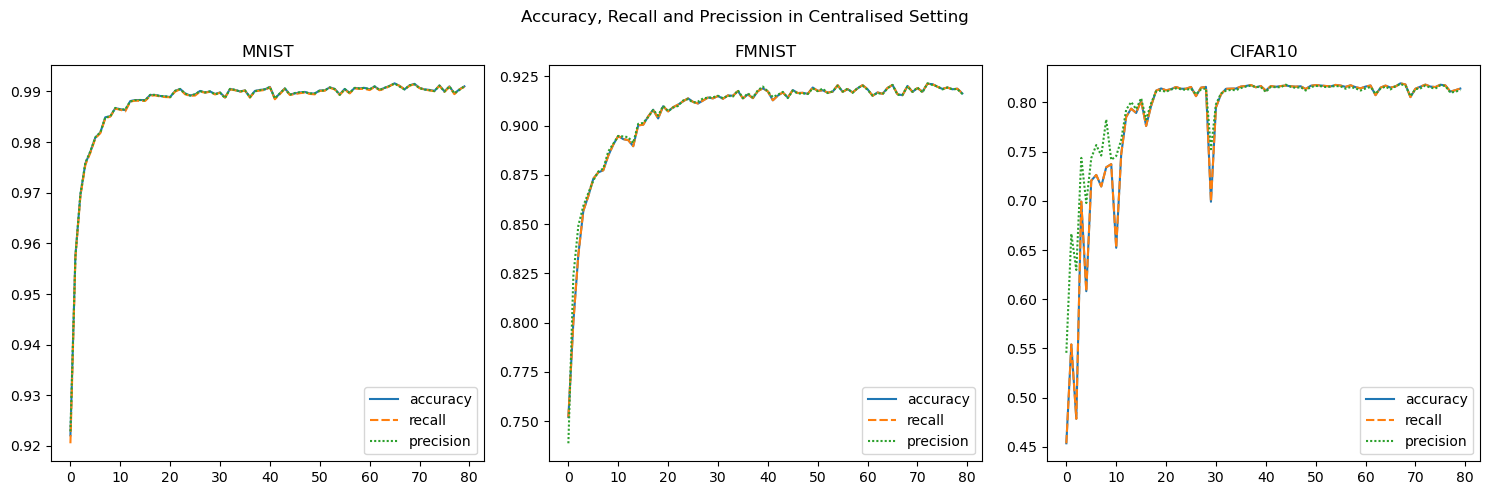

In [16]:
datasets = {"MNIST": mnist_cen_test, "FMNIST":fmnist_cen_test, "CIFAR10":cifar10_cen_test}
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(15, 5))

for (dataset_name, dataset_frame), ax in zip(datasets.items(), axes):
    sns.lineplot(dataset_frame[['accuracy', 'recall', 'precision']], ax=ax)
    ax.set_title(dataset_name)

fig.suptitle("Accuracy, Recall and Precission in Centralised Setting")
fig.tight_layout()

## Section II: Sattler et al. and Briggs et al. HyperParameter FineTuning

## Section III: K-Means Elbow

In [4]:
def label_clusters(row):
    unique_values = row.unique()
    letter_digit = {}
    for number, value in enumerate(unique_values):
        letter_digit[value] = number
    row = row.replace(letter_digit)
    return row

def calculate_metric(row, metric, true_labels):
    return(metric(row, true_labels))

# Standard: "DATASET_{NUMBER OF CLIENTS}_{SPLIT TYPE}"
# 'NB' - Nonoverlaping Balanced
# 'NI' - Nonoverlaping Imbalanced
# 'OB' - Overlaping Balanced
# 'OI' - Overlaping Imbalanced
datasets = ['MNIST', 'FMNIST', 'CIFAR10']
no_of_clients = ['15', '30']
split_types = ['nonoverlaping', 'overlaping']
split_balance = ['balanced', 'imbalanced']
scenarios = [
    f"{dataset}_{clients}_{split}_{balance}"
    for dataset in datasets
    for clients in no_of_clients
    for split in split_types
    for balance in split_balance
]
elbows = ['2', '3', '4', '6', '8', '10']

clustering_avg_per_scenario = {
    scenario: pd.DataFrame(index = elbows, columns=['RAND', 'AMI', 'COM'])
    # RAND: Rand Score
    # AMI: Adjusted Mutual Information Score
    # COM: Cluster Completeness
    # HOM: Homogeneity Score
    for scenario in scenarios
}

learning_avg_per_scenario = {
    scenario: pd.DataFrame(index = elbows, columns=['PA', 'PF1', 'GA', 'GF1'])
    # PA: Personalization Accuracy
    # PF1: Personalization F1score
    # GA: Generalization Accuracy
    # GF1: Generalization F1Score
    for scenario in scenarios
}

TRUE_LABELS = {
    'nonoverlaping_balanced_15': [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
    'nonoverlaping_imbalanced_15': [1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
    'overlaping_balanced_15': [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
    'overlaping_imbalanced_15': [1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
    'nonoverlaping_balanced_30': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    'nonoverlaping_imbalanced_30': [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    'overlaping_balanced_30': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    'overlaping_imbalanced_30': [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3]
}

### Clustering Evaluation

In [5]:
for dataset in datasets:
    for no_clients in no_of_clients:
        for split in split_types:
            for balance in split_balance:
                ROOT = os.path.join(os.getcwd(), f'elbow_experiments/{dataset}/{split}/{balance}/{no_clients}')
                ALT_ROOT = os.path.join(os.getcwd(), f'experiments/{dataset}/{split}/{balance}/{no_clients}')
                # I. Read Individual CSVs
                C2_ATT = pd.read_csv(os.path.join(ROOT, f"2_{dataset}_{split}_{balance}_{no_clients}/results/cluster_id_mapping.csv"))
                C3_ATT = pd.read_csv(os.path.join(ALT_ROOT, f"kmeans_{dataset}_{split}_{balance}_{no_clients}/results/cluster_id_mapping.csv"))
                C4_ATT = pd.read_csv(os.path.join(ROOT, f"4_{dataset}_{split}_{balance}_{no_clients}/results/cluster_id_mapping.csv"))
                C6_ATT = pd.read_csv(os.path.join(ROOT, f"6_{dataset}_{split}_{balance}_{no_clients}/results/cluster_id_mapping.csv"))
                C8_ATT = pd.read_csv(os.path.join(ROOT, f"8_{dataset}_{split}_{balance}_{no_clients}/results/cluster_id_mapping.csv"))
                C10_ATT = pd.read_csv(os.path.join(ROOT, f"10_{dataset}_{split}_{balance}_{no_clients}/results/cluster_id_mapping.csv"))
                
                # II. Apply additional column (true labels) to each dataframe
                true_labels = TRUE_LABELS[f'{split}_{balance}_{no_clients}']
                C2_ATT_GROUPED = C2_ATT.apply(label_clusters, axis=1)
                C3_ATT_GROUPED = C3_ATT.apply(label_clusters, axis=1)
                C4_ATT_GROUPED = C4_ATT.apply(label_clusters, axis=1)
                C6_ATT_GROUPED = C6_ATT.apply(label_clusters, axis=1)
                C8_ATT_GROUPED = C8_ATT.apply(label_clusters, axis=1)
                C10_ATT_GROUPED = C10_ATT.apply(label_clusters, axis=1)
                
                # III. Calculate RAND SCORES  for each clustering
                RAND_SCORES = pd.DataFrame(columns=elbows, index=range(50))
                RAND_SCORES['2'] = C2_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                RAND_SCORES['3'] = C3_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                RAND_SCORES['4'] = C4_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                RAND_SCORES['6'] = C6_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                RAND_SCORES['8'] = C8_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                RAND_SCORES['10'] = C10_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                
                # IV. Calculate MIS Scores for each clustering.
                MIS_SCORES = pd.DataFrame(columns=elbows, index=range(50))
                MIS_SCORES['2'] = C2_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_mutual_info_score, true_labels = true_labels, axis=1)
                MIS_SCORES['3'] = C3_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_mutual_info_score, true_labels = true_labels, axis=1)
                MIS_SCORES['4'] = C4_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_mutual_info_score, true_labels = true_labels, axis=1)
                MIS_SCORES['6'] = C6_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_mutual_info_score, true_labels = true_labels, axis=1)
                MIS_SCORES['8'] = C8_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_mutual_info_score, true_labels = true_labels, axis=1)
                MIS_SCORES['10'] = C10_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_mutual_info_score, true_labels = true_labels, axis=1)

                # VI. Calculate COM Scores for each clustering.
                COM_SCORES = pd.DataFrame(columns=elbows, index=range(50))
                COM_SCORES['2'] = C2_ATT_GROUPED.apply(calculate_metric, metric = metrics.completeness_score, true_labels = true_labels, axis=1)
                COM_SCORES['3'] = C3_ATT_GROUPED.apply(calculate_metric, metric = metrics.completeness_score, true_labels = true_labels, axis=1)
                COM_SCORES['4'] = C4_ATT_GROUPED.apply(calculate_metric, metric = metrics.completeness_score, true_labels = true_labels, axis=1)
                COM_SCORES['6'] = C6_ATT_GROUPED.apply(calculate_metric, metric = metrics.completeness_score, true_labels = true_labels, axis=1)
                COM_SCORES['8'] = C8_ATT_GROUPED.apply(calculate_metric, metric = metrics.completeness_score, true_labels = true_labels, axis=1)
                COM_SCORES['10'] = C10_ATT_GROUPED.apply(calculate_metric, metric = metrics.completeness_score, true_labels = true_labels, axis=1)

                # VII. Calculating mean scores for each metric                
                key = f'{dataset}_{no_clients}_{split}_{balance}'
                clustering_avg_per_scenario[key]['RAND'] = RAND_SCORES.mean()
                clustering_avg_per_scenario[key]['AMI'] = MIS_SCORES.mean()
                clustering_avg_per_scenario[key]['COM'] = COM_SCORES.mean()

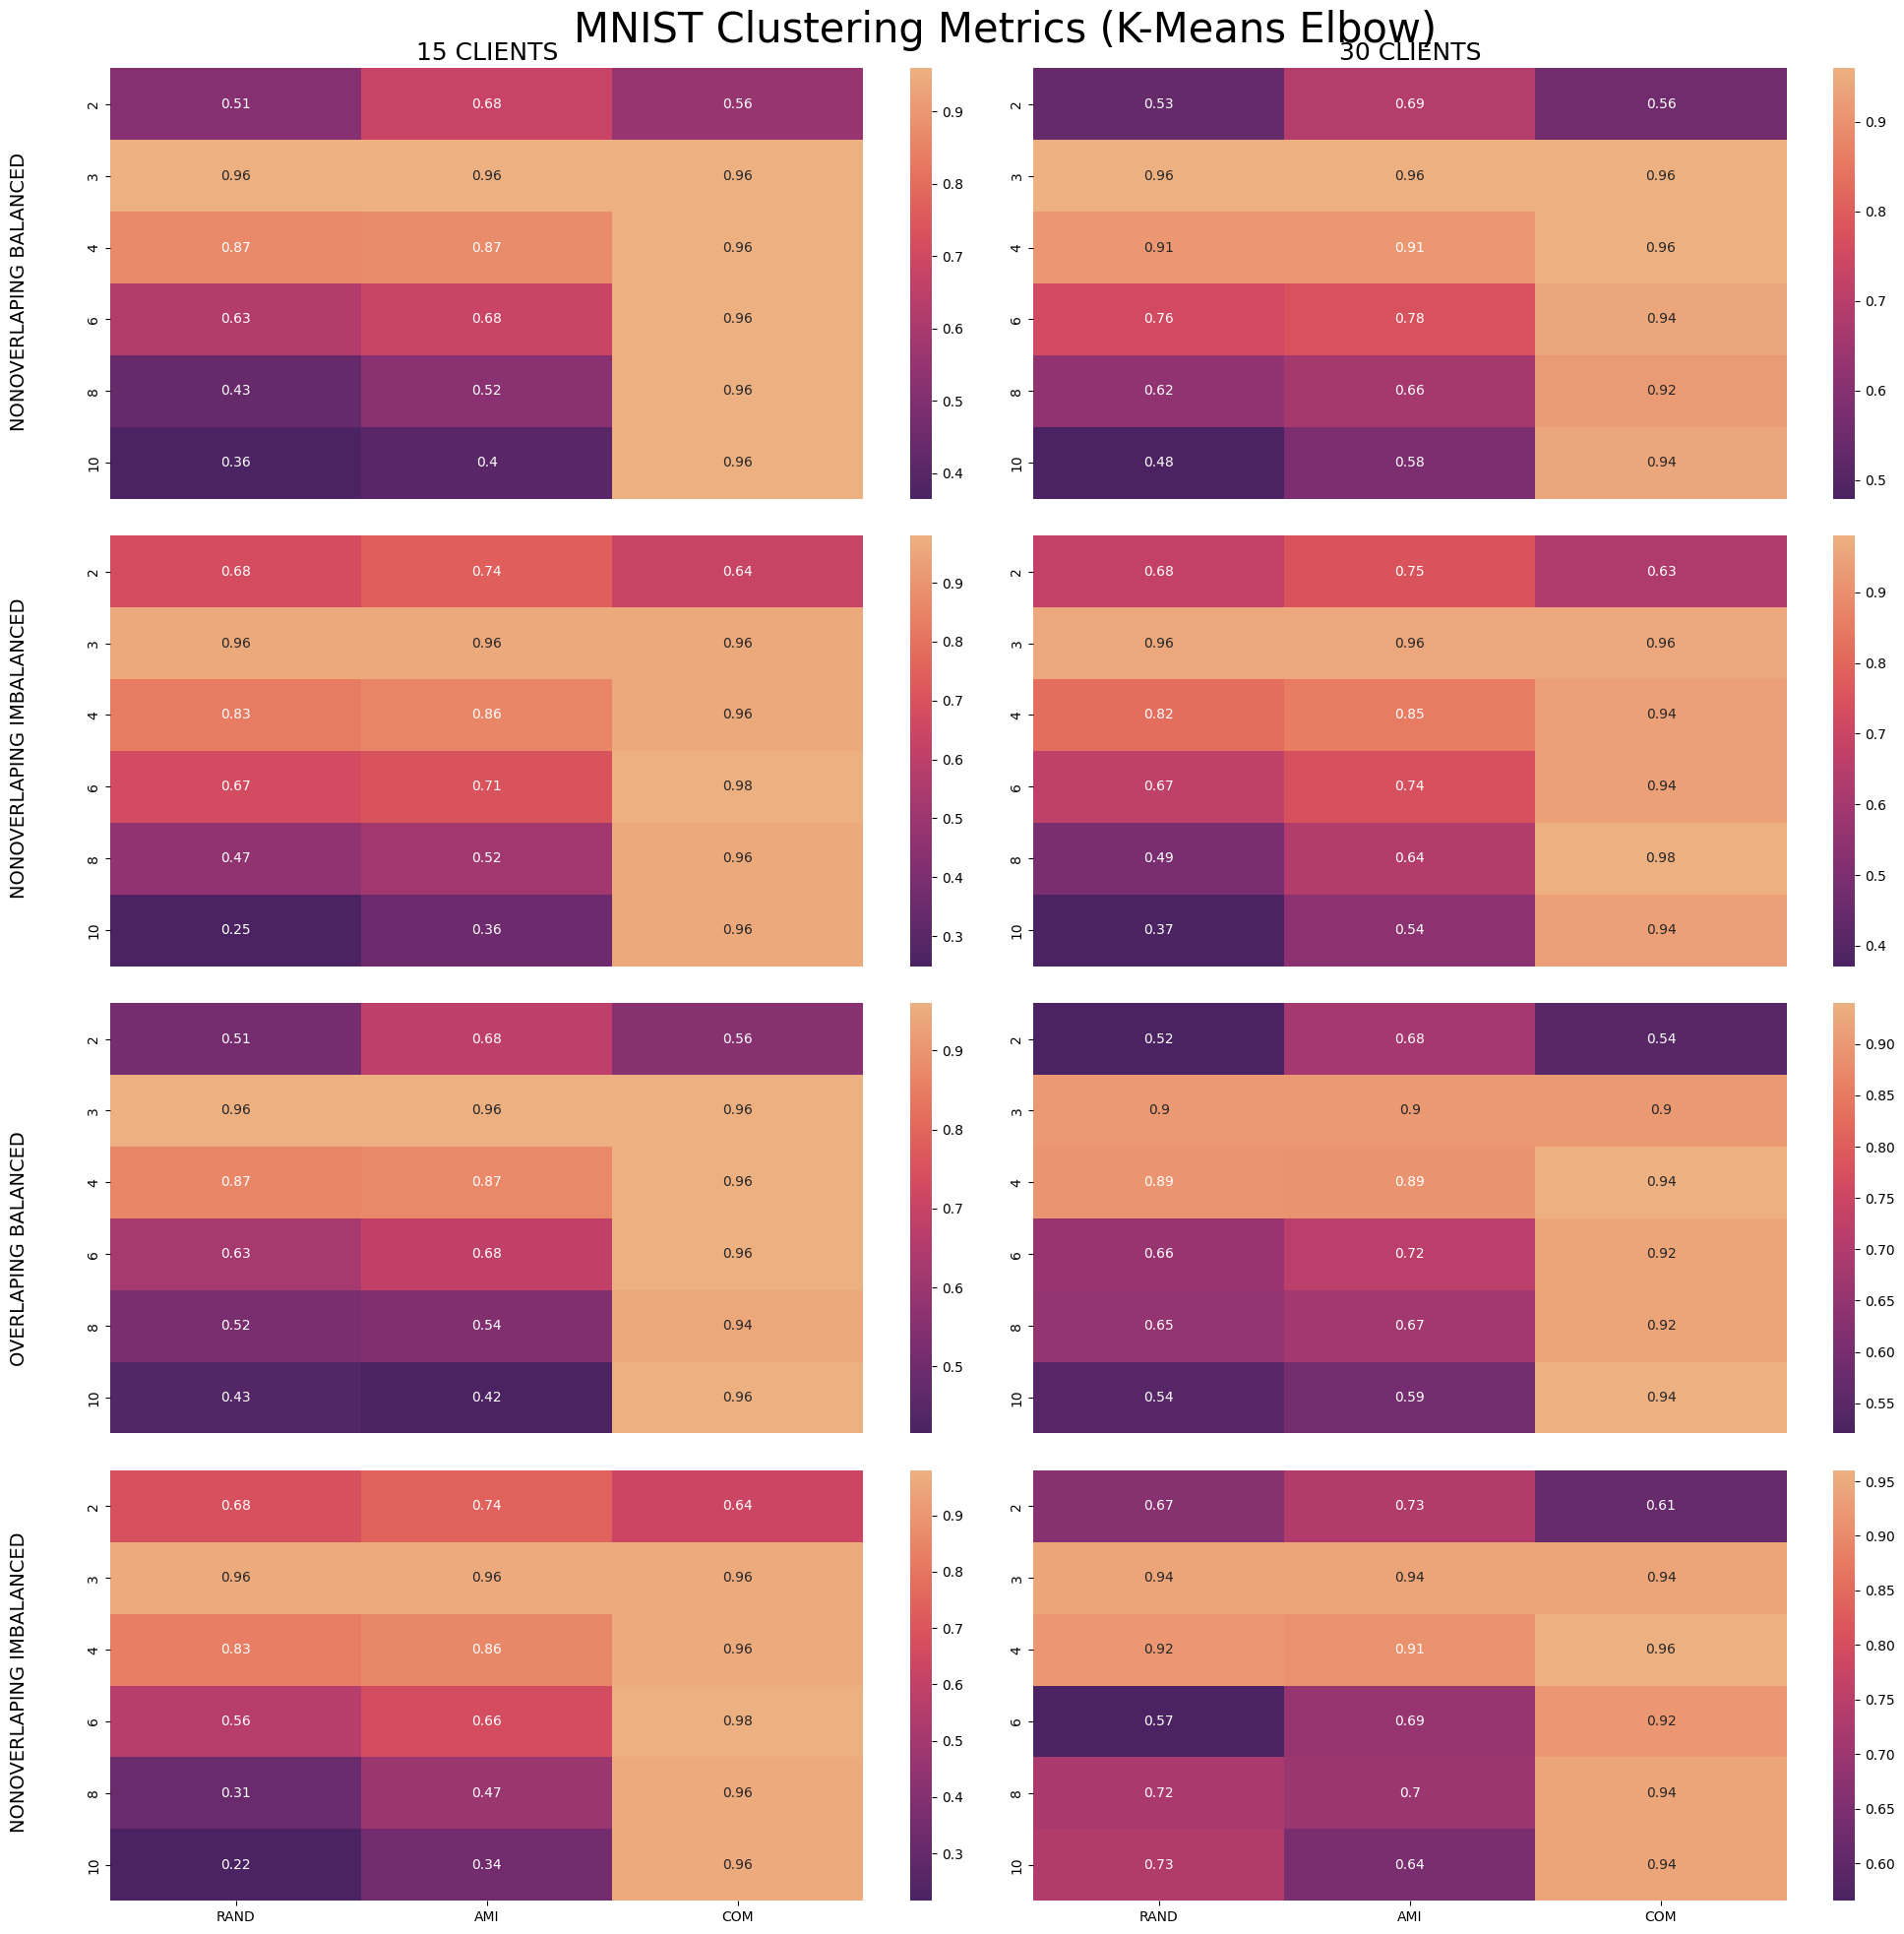

In [7]:
fig, ax = plt.subplots(4, 2, figsize=(20, 20))
fig.suptitle("MNIST Clustering Metrics (K-Means Elbow)", fontsize=30)

# FMNIST NONOVERLAPING BALANCED
sns.heatmap(clustering_avg_per_scenario['MNIST_15_nonoverlaping_balanced'], ax=ax[0][0], annot=True, cmap=PALETTE, cbar=True)
ax[0][0].set_title('15 CLIENTS', fontsize=18)
ax[0][0].get_xaxis().set_ticks([])
sns.heatmap(clustering_avg_per_scenario['MNIST_30_nonoverlaping_balanced'], ax=ax[0][1], annot=True, cmap=PALETTE)
ax[0][1].set_title('30 CLIENTS', fontsize=18)
ax[0][1].get_xaxis().set_ticks([])
ax[0][0].text(-0.4, 5, 'NONOVERLAPING BALANCED', fontsize=14, rotation = 270, rotation_mode = 'default', transform_rotates_text=True)

# FMNIST NONOVERLAPING IMBALANCED
sns.heatmap(clustering_avg_per_scenario['MNIST_15_nonoverlaping_imbalanced'], ax=ax[1][0], annot=True, cmap=PALETTE, cbar=True)
ax[1][0].get_xaxis().set_ticks([])
sns.heatmap(clustering_avg_per_scenario['MNIST_30_nonoverlaping_imbalanced'], ax=ax[1][1], annot=True, cmap=PALETTE)
ax[1][1].get_xaxis().set_ticks([])
ax[1][0].text(-0.4, 5, 'NONOVERLAPING IMBALANCED', fontsize=14, rotation = 270, rotation_mode = 'default', transform_rotates_text=True)

# FMNIST OVERLAPING BALANCED
sns.heatmap(clustering_avg_per_scenario['MNIST_15_overlaping_balanced'], ax=ax[2][0], annot=True, cmap=PALETTE, cbar=True)
ax[2][0].get_xaxis().set_ticks([])
sns.heatmap(clustering_avg_per_scenario['MNIST_30_overlaping_balanced'], ax=ax[2][1], annot=True, cmap=PALETTE)
ax[2][1].get_xaxis().set_ticks([])
ax[2][0].text(-0.4, 5, 'OVERLAPING BALANCED', fontsize=14, rotation = 270, rotation_mode = 'default', transform_rotates_text=True)

# FMNIST OVERLAPING IMBALANCED
sns.heatmap(clustering_avg_per_scenario['MNIST_15_overlaping_imbalanced'], ax=ax[3][0], annot=True, cmap=PALETTE, cbar=True)
sns.heatmap(clustering_avg_per_scenario['MNIST_30_overlaping_imbalanced'], ax=ax[3][1], annot=True, cmap=PALETTE)
ax[3][0].text(-0.4, 5, 'NONOVERLAPING IMBALANCED', fontsize=14, rotation = 270, rotation_mode = 'default', transform_rotates_text=True)

plt.tight_layout()

Text(0.5, 1.0, 'FMNIST 30 OVERLAPING BALANCED')

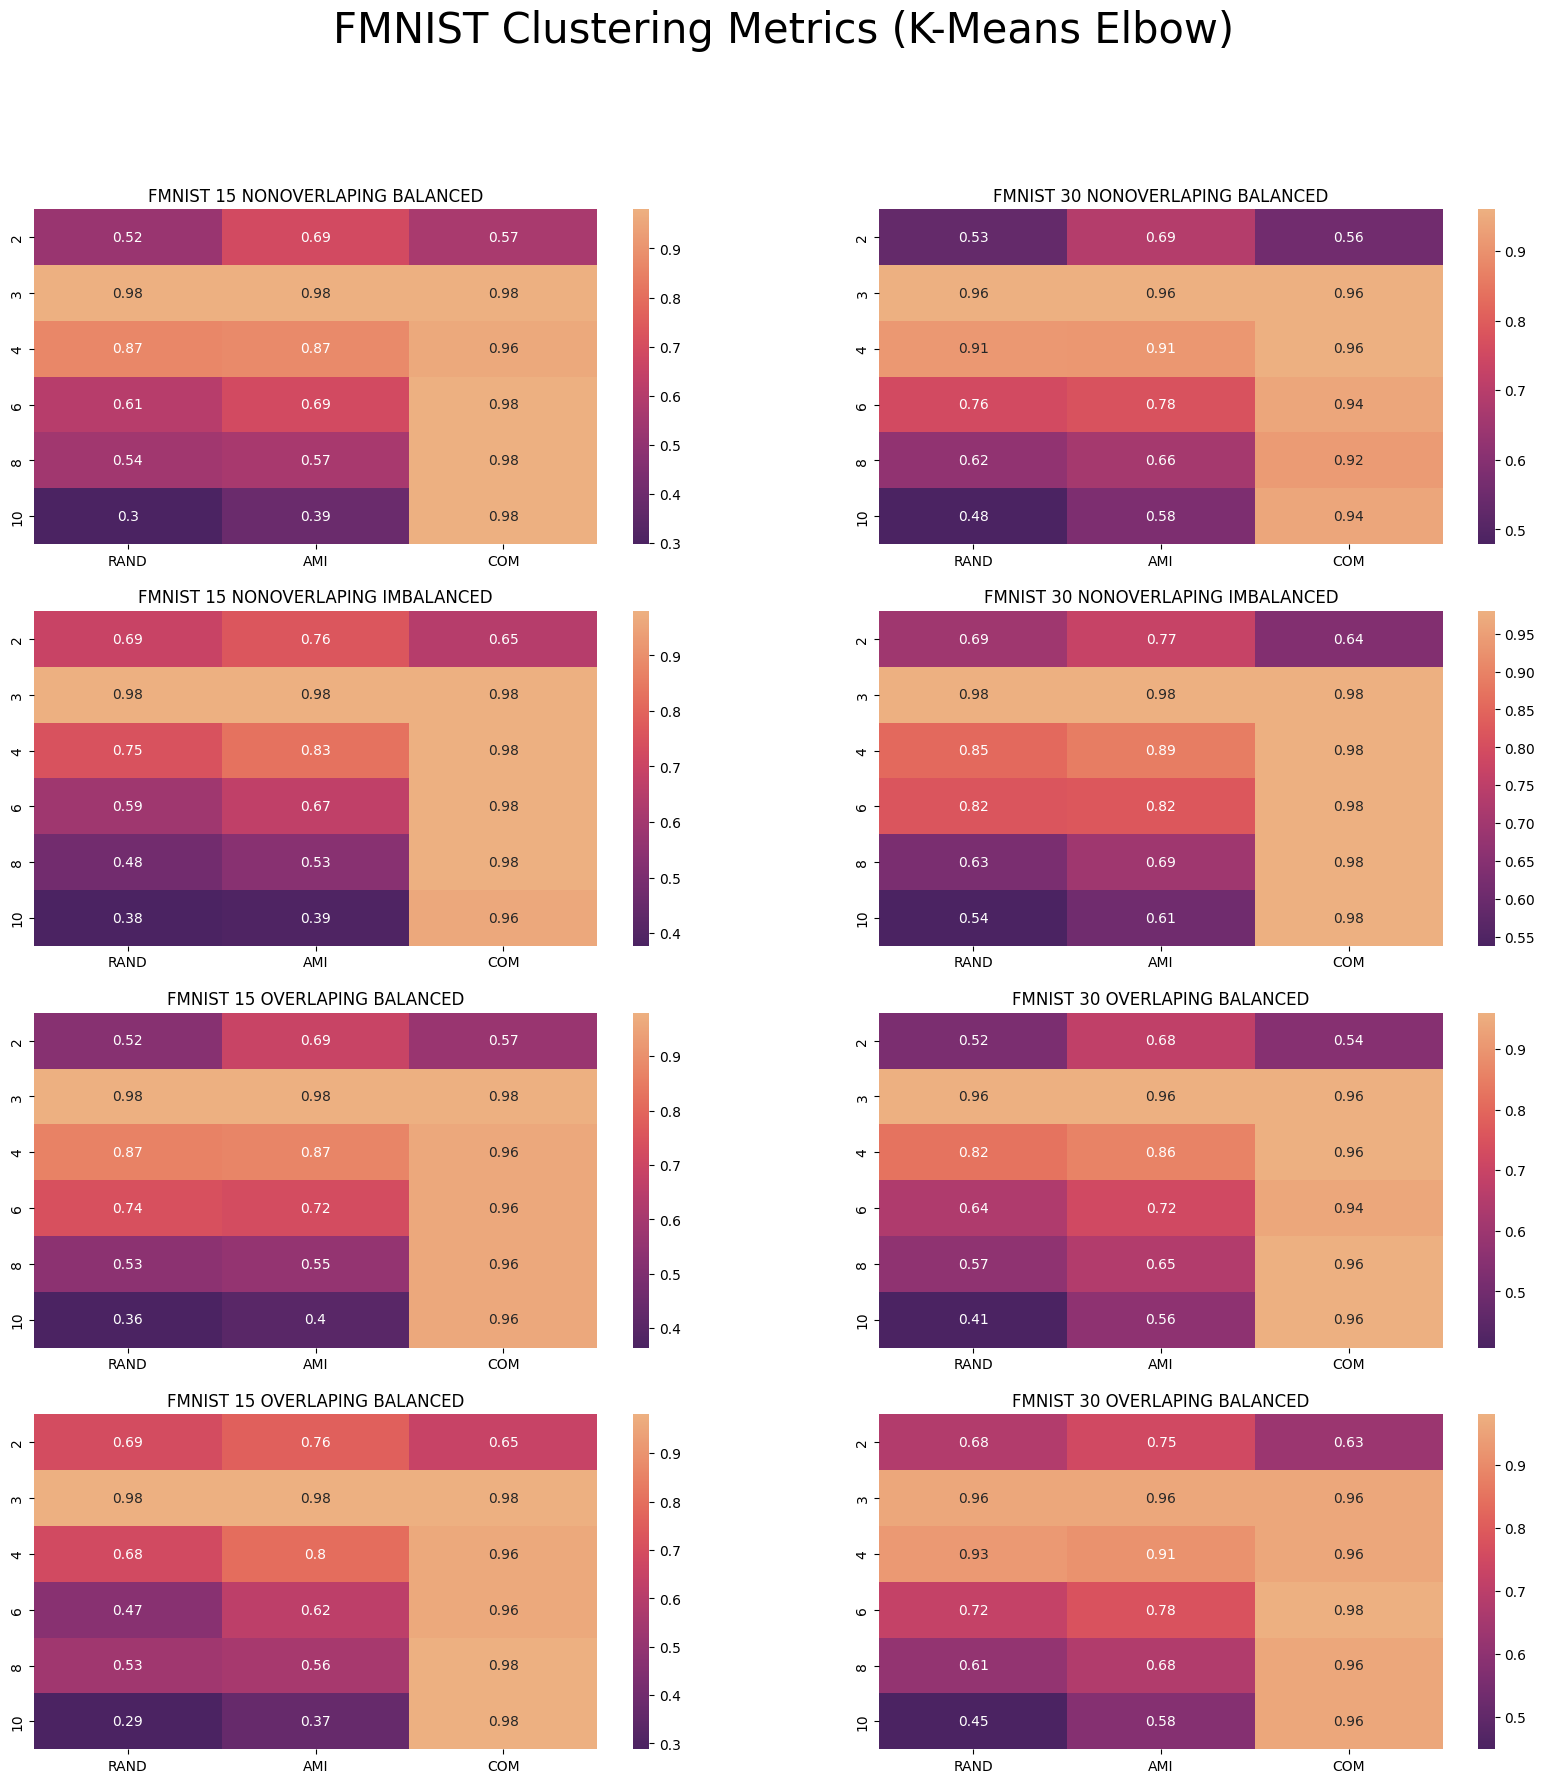

In [8]:
fig, ax = plt.subplots(4, 2, figsize=(20, 20))
fig.suptitle("FMNIST Clustering Metrics (K-Means Elbow)", fontsize=30)

# FMNIST NONOVERLAPING BALANCED
sns.heatmap(clustering_avg_per_scenario['FMNIST_15_nonoverlaping_balanced'], ax=ax[0][0], annot=True, cmap=PALETTE)
ax[0][0].set_title('FMNIST 15 NONOVERLAPING BALANCED')

sns.heatmap(clustering_avg_per_scenario['MNIST_30_nonoverlaping_balanced'], ax=ax[0][1], annot=True, cmap=PALETTE)
ax[0][1].set_title('FMNIST 30 NONOVERLAPING BALANCED')

# FMNIST NONOVERLAPING IMBALANCED
sns.heatmap(clustering_avg_per_scenario['FMNIST_15_nonoverlaping_imbalanced'], ax=ax[1][0], annot=True, cmap=PALETTE)
ax[1][0].set_title('FMNIST 15 NONOVERLAPING IMBALANCED')

sns.heatmap(clustering_avg_per_scenario['FMNIST_30_nonoverlaping_imbalanced'], ax=ax[1][1], annot=True, cmap=PALETTE)
ax[1][1].set_title('FMNIST 30 NONOVERLAPING IMBALANCED')

# FMNIST OVERLAPING BALANCED
sns.heatmap(clustering_avg_per_scenario['FMNIST_15_overlaping_balanced'], ax=ax[2][0], annot=True, cmap=PALETTE)
ax[2][0].set_title('FMNIST 15 OVERLAPING BALANCED')

sns.heatmap(clustering_avg_per_scenario['FMNIST_30_overlaping_balanced'], ax=ax[2][1], annot=True, cmap=PALETTE)
ax[2][1].set_title('FMNIST 30 OVERLAPING BALANCED')

# FMNIST OVERLAPING IMBALANCED
sns.heatmap(clustering_avg_per_scenario['FMNIST_15_overlaping_imbalanced'], ax=ax[3][0], annot=True, cmap=PALETTE)
ax[3][0].set_title('FMNIST 15 OVERLAPING BALANCED')

sns.heatmap(clustering_avg_per_scenario['FMNIST_30_overlaping_imbalanced'], ax=ax[3][1], annot=True, cmap=PALETTE)
ax[3][1].set_title('FMNIST 30 OVERLAPING BALANCED')

Text(0.5, 1.0, 'CIFAR10 30 OVERLAPING BALANCED')

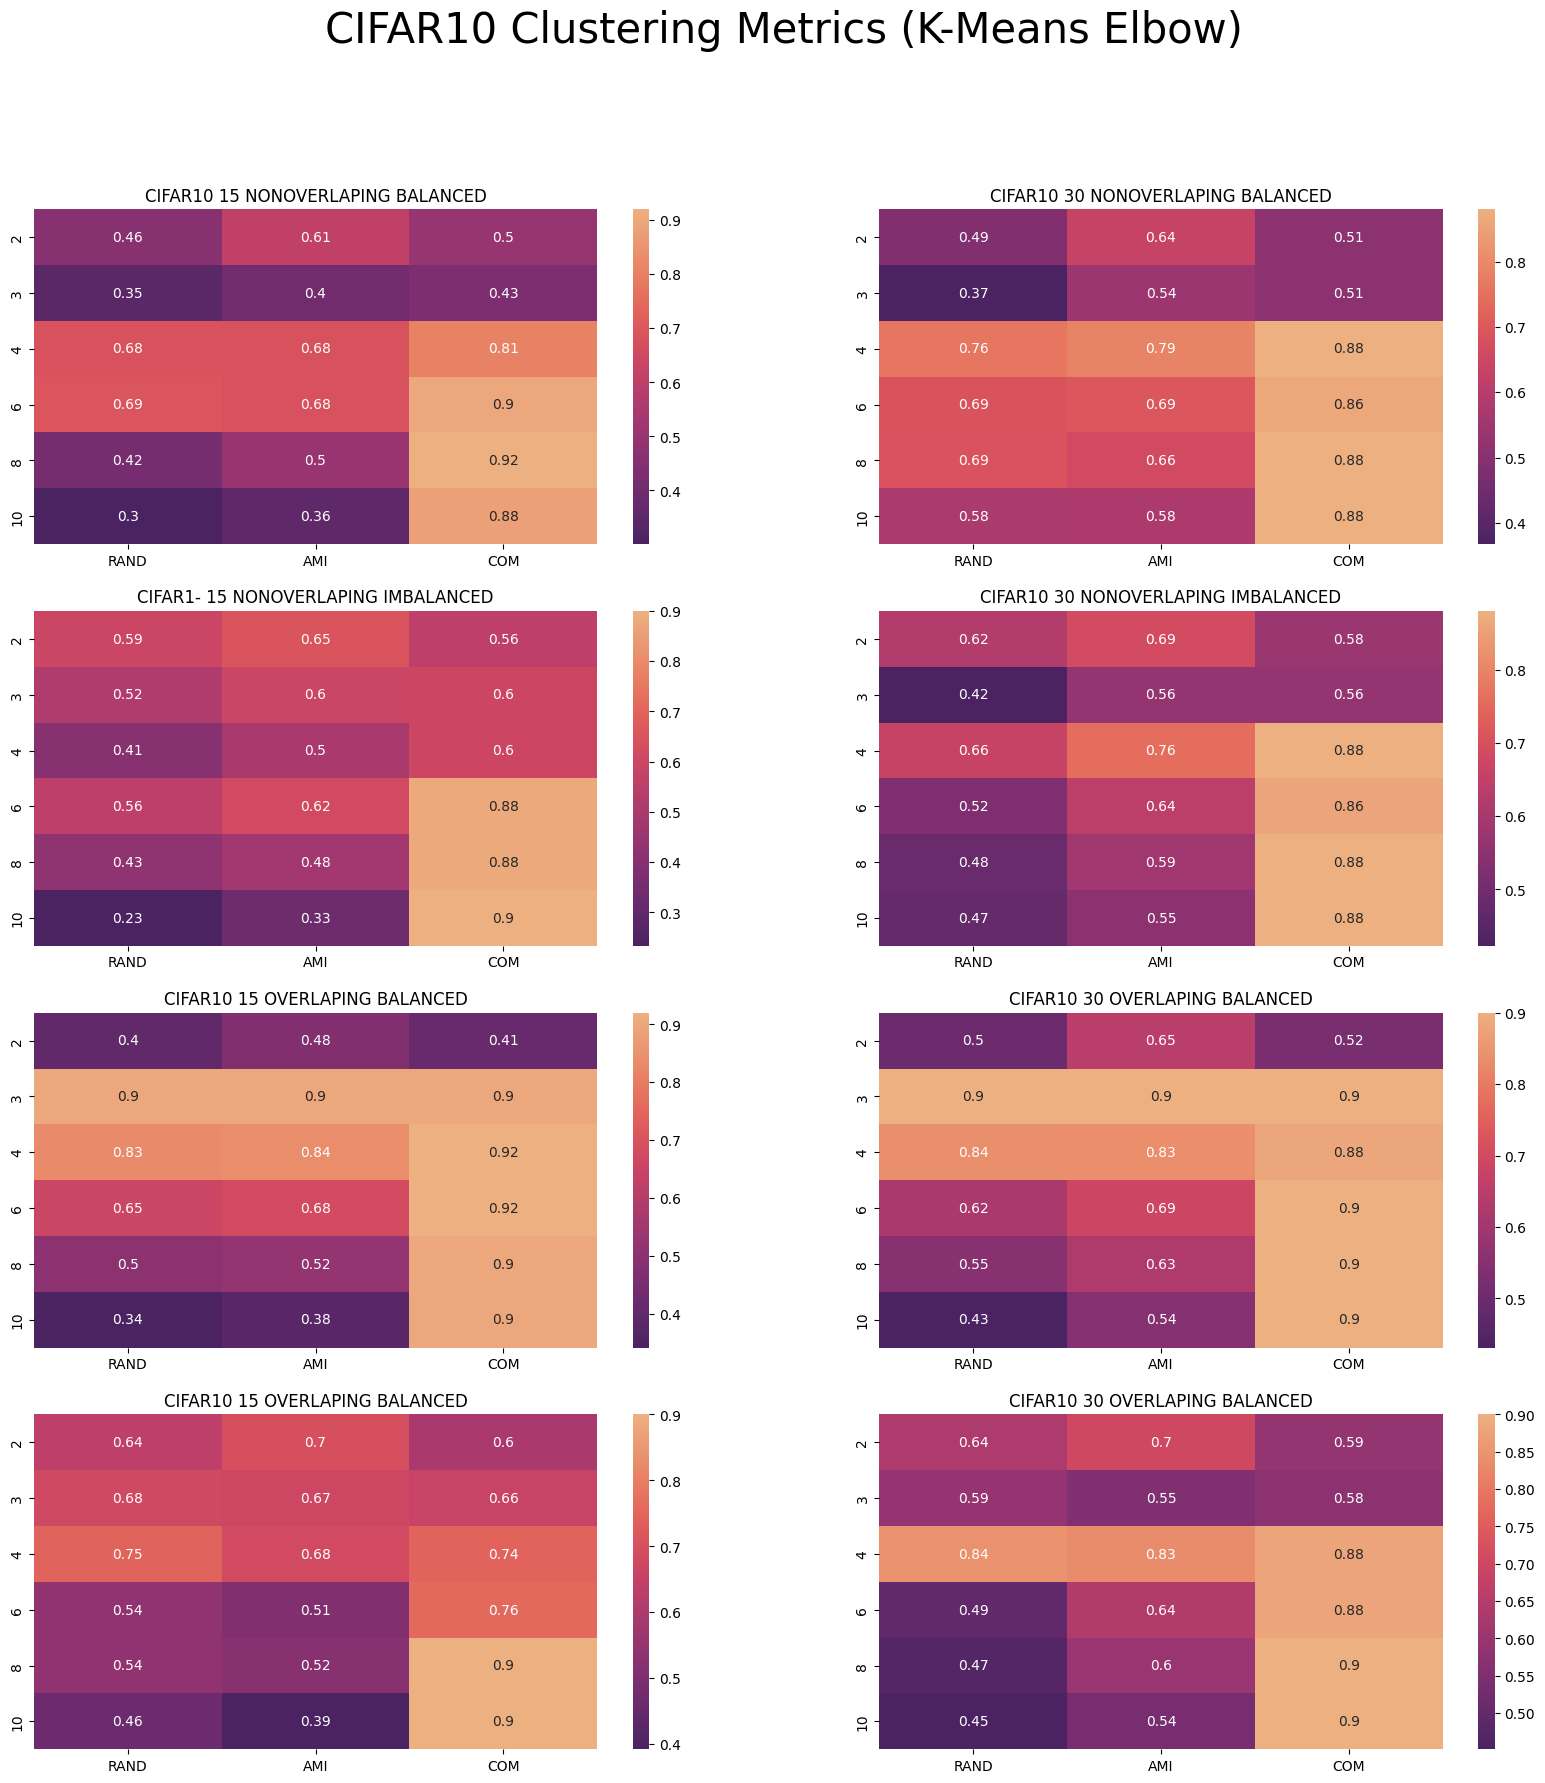

In [9]:
fig, ax = plt.subplots(4, 2, figsize=(20, 20))
fig.suptitle("CIFAR10 Clustering Metrics (K-Means Elbow)", fontsize=30)

# FMNIST NONOVERLAPING BALANCED
sns.heatmap(clustering_avg_per_scenario['CIFAR10_15_nonoverlaping_balanced'], ax=ax[0][0], annot=True, cmap=PALETTE)
ax[0][0].set_title('CIFAR10 15 NONOVERLAPING BALANCED')

sns.heatmap(clustering_avg_per_scenario['CIFAR10_30_nonoverlaping_balanced'], ax=ax[0][1], annot=True, cmap=PALETTE)
ax[0][1].set_title('CIFAR10 30 NONOVERLAPING BALANCED')

# FMNIST NONOVERLAPING IMBALANCED
sns.heatmap(clustering_avg_per_scenario['CIFAR10_15_nonoverlaping_imbalanced'], ax=ax[1][0], annot=True, cmap=PALETTE)
ax[1][0].set_title('CIFAR1- 15 NONOVERLAPING IMBALANCED')

sns.heatmap(clustering_avg_per_scenario['CIFAR10_30_nonoverlaping_imbalanced'], ax=ax[1][1], annot=True, cmap=PALETTE)
ax[1][1].set_title('CIFAR10 30 NONOVERLAPING IMBALANCED')

# FMNIST OVERLAPING BALANCED
sns.heatmap(clustering_avg_per_scenario['CIFAR10_15_overlaping_balanced'], ax=ax[2][0], annot=True, cmap=PALETTE)
ax[2][0].set_title('CIFAR10 15 OVERLAPING BALANCED')

sns.heatmap(clustering_avg_per_scenario['CIFAR10_30_overlaping_balanced'], ax=ax[2][1], annot=True, cmap=PALETTE)
ax[2][1].set_title('CIFAR10 30 OVERLAPING BALANCED')

# FMNIST OVERLAPING IMBALANCED
sns.heatmap(clustering_avg_per_scenario['CIFAR10_15_overlaping_imbalanced'], ax=ax[3][0], annot=True, cmap=PALETTE)
ax[3][0].set_title('CIFAR10 15 OVERLAPING BALANCED')

sns.heatmap(clustering_avg_per_scenario['CIFAR10_30_overlaping_imbalanced'], ax=ax[3][1], annot=True, cmap=PALETTE)
ax[3][1].set_title('CIFAR10 30 OVERLAPING BALANCED')

### Performance Evaluation

In [10]:
for dataset in datasets:
    for no_clients in no_of_clients:
        for split in split_types:
            for balance in split_balance:
            
                # I. Read Individual CSVs (Personalization)
                ROOT = os.path.join(os.getcwd(), f'elbow_experiments/{dataset}/{split}/{balance}/{no_clients}')
                ALT_ROOT = os.path.join(os.getcwd(), f'experiments/{dataset}/{split}/{balance}/{no_clients}')
                C2_global_model_on_nodes = pd.read_csv(os.path.join(ROOT, f"2_{dataset}_{split}_{balance}_{no_clients}/results/after_update_metrics.csv"))
                C3_global_model_on_nodes = pd.read_csv(os.path.join(ALT_ROOT, f"kmeans_{dataset}_{split}_{balance}_{no_clients}/results/after_update_metrics.csv"))
                C4_global_model_on_nodes = pd.read_csv(os.path.join(ROOT, f"4_{dataset}_{split}_{balance}_{no_clients}/results/after_update_metrics.csv"))
                C6_global_model_on_nodes = pd.read_csv(os.path.join(ROOT, f"6_{dataset}_{split}_{balance}_{no_clients}/results/after_update_metrics.csv"))
                C8_global_model_on_nodes = pd.read_csv(os.path.join(ROOT, f"8_{dataset}_{split}_{balance}_{no_clients}/results/after_update_metrics.csv"))
                C10_global_model_on_nodes = pd.read_csv(os.path.join(ROOT, f"10_{dataset}_{split}_{balance}_{no_clients}/results/after_update_metrics.csv"))

                # II. Calcualting Personalization (Accuracy + F1 SCORE)
                key = f'{dataset}_{no_clients}_{split}_{balance}'
                learning_avg_per_scenario[key].loc['2', 'PA'] = C2_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['3', 'PA'] = C3_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['4', 'PA'] = C4_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['6', 'PA'] = C6_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['8', 'PA'] = C8_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['10', 'PA'] = C10_global_model_on_nodes['accuracy'].mean()

                learning_avg_per_scenario[key].loc['2', 'PF1'] = C2_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['3', 'PF1']  = C3_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['4', 'PF1'] = C4_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['6', 'PF1']  = C6_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['8', 'PF1'] = C8_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['10', 'PF1'] = C10_global_model_on_nodes['f1score'].mean()
                
                # III. Read Individual CSVs (Generalization)
                gen_C2_global_model_on_nodes = pd.read_csv(os.path.join(ROOT, f"2_{dataset}_{split}_{balance}_{no_clients}/results/after_update_generalizability.csv"))
                gen_C3_global_model_on_nodes = pd.read_csv(os.path.join(ALT_ROOT, f"kmeans_{dataset}_{split}_{balance}_{no_clients}/results/after_update_generalizability.csv"))
                gen_C4_global_model_on_nodes = pd.read_csv(os.path.join(ROOT, f"4_{dataset}_{split}_{balance}_{no_clients}/results/after_update_generalizability.csv"))
                gen_C6_global_model_on_nodes = pd.read_csv(os.path.join(ROOT, f"6_{dataset}_{split}_{balance}_{no_clients}/results/after_update_generalizability.csv"))
                gen_C8_global_model_on_nodes = pd.read_csv(os.path.join(ROOT, f"8_{dataset}_{split}_{balance}_{no_clients}/results/after_update_generalizability.csv"))
                gen_C10_global_model_on_nodes = pd.read_csv(os.path.join(ROOT, f"10_{dataset}_{split}_{balance}_{no_clients}/results/after_update_generalizability.csv"))

                # IV. Calcualting Generalization (Accuracy + F1 SCORE)
                learning_avg_per_scenario[key].loc['2', 'GA'] = gen_C2_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['3', 'GA'] = gen_C3_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['4', 'GA']= gen_C4_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['6', 'GA'] = gen_C6_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['8', 'GA'] = gen_C8_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['10', 'GA'] = gen_C10_global_model_on_nodes['accuracy'].mean()

                learning_avg_per_scenario[key].loc['2', 'GF1'] = gen_C2_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['3', 'GF1'] = gen_C3_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['4', 'GF1'] = gen_C4_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['6', 'GF1'] = gen_C6_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['8', 'GF1'] = gen_C8_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['10', 'GF1'] = gen_C10_global_model_on_nodes['f1score'].mean()

Text(0.5, 1.0, 'MNIST 30 OVERLAPING BALANCED')

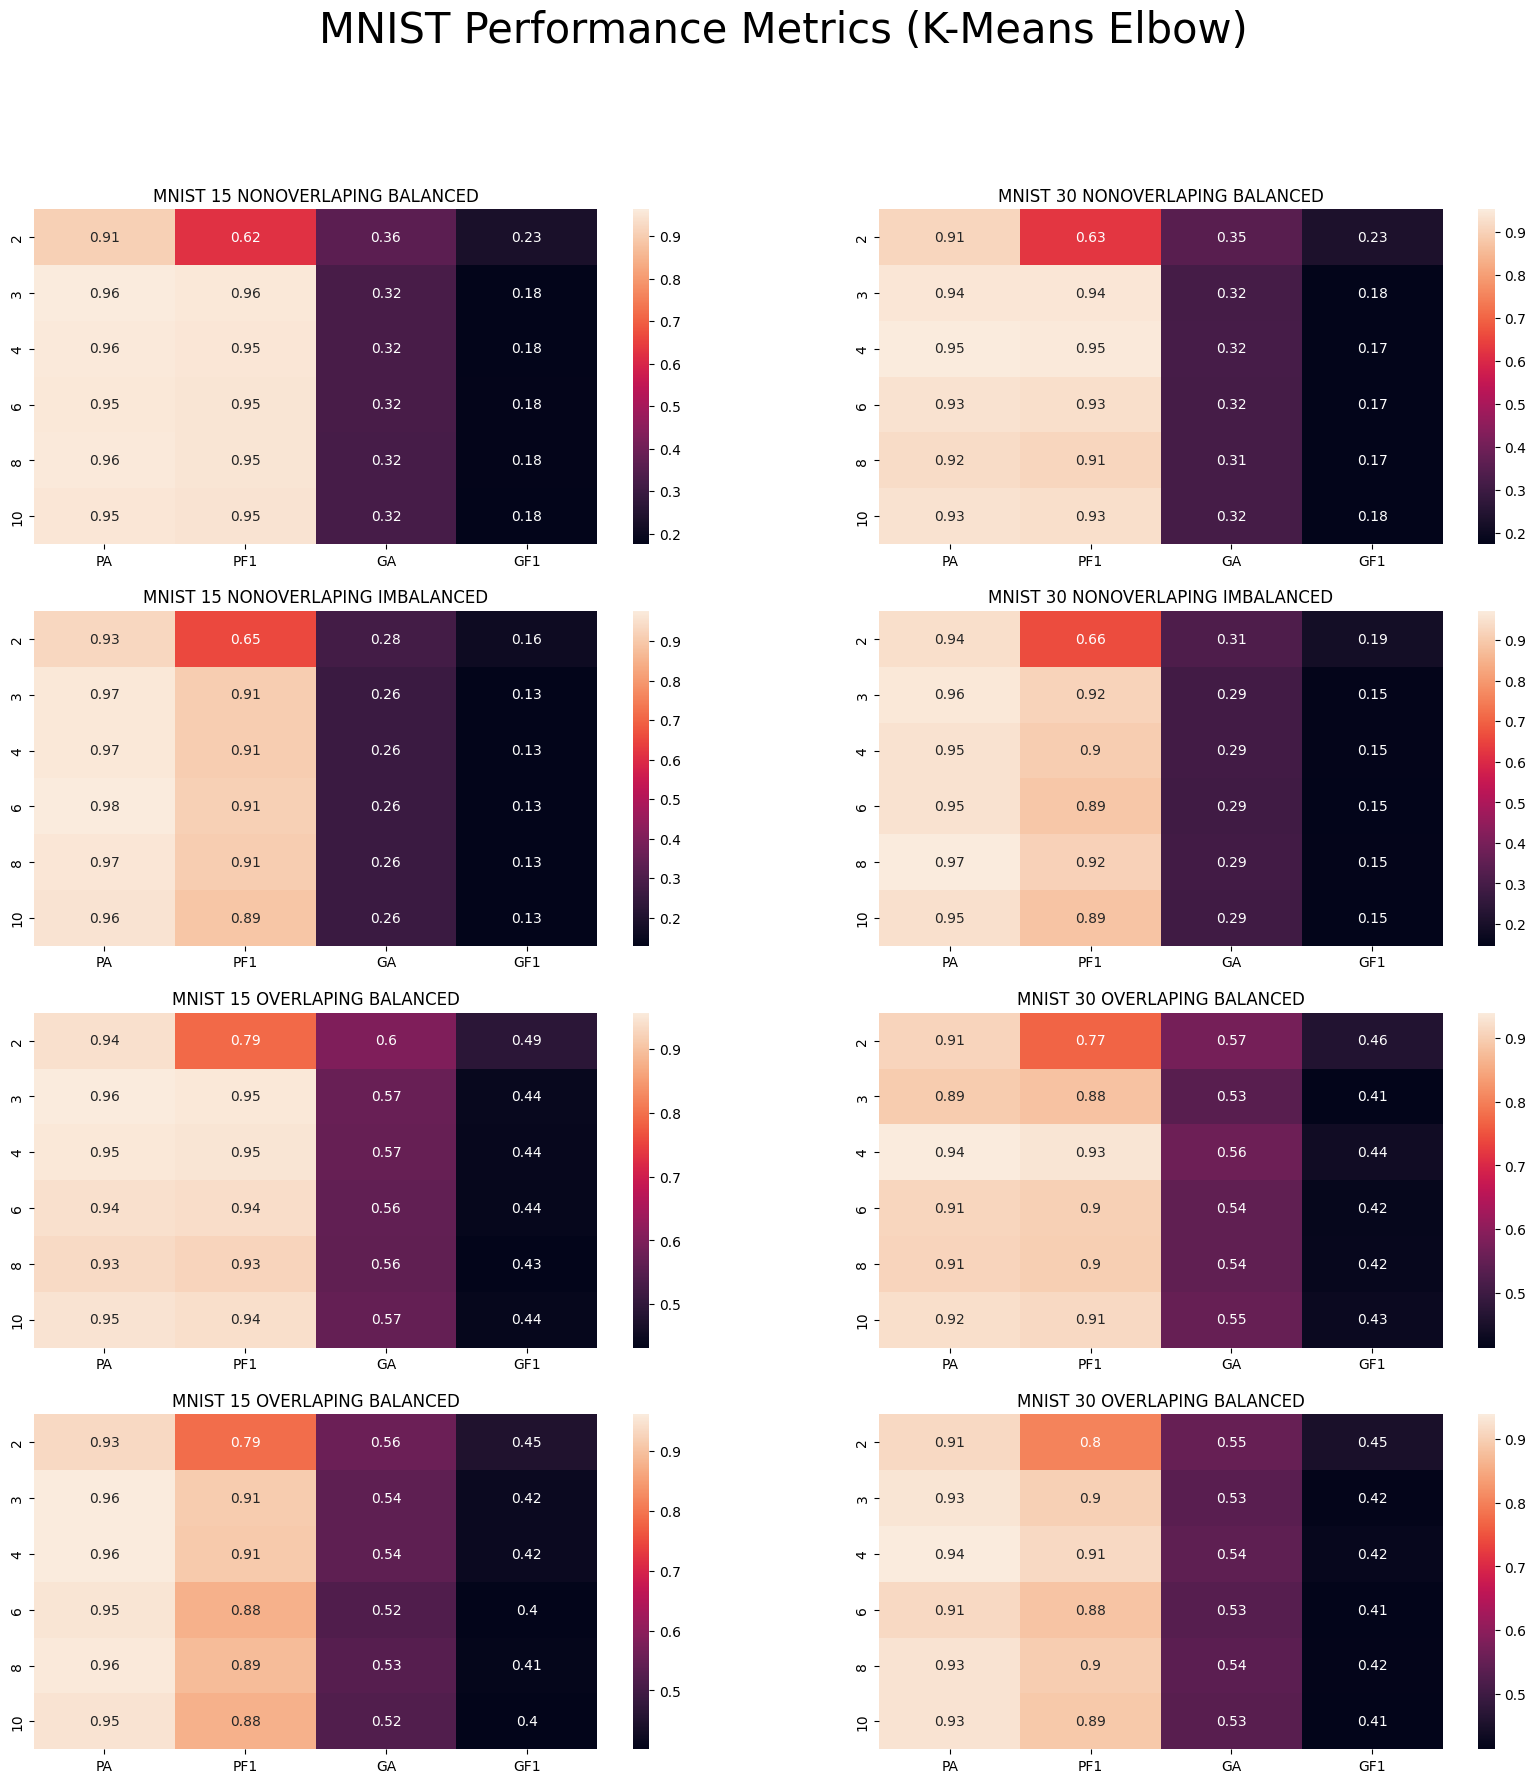

In [11]:
# MNIST NONOVERLAPING BALANCED
fig, ax = plt.subplots(4, 2, figsize=(20, 20))
fig.suptitle("MNIST Performance Metrics (K-Means Elbow)", fontsize=30)

sns.heatmap(learning_avg_per_scenario['MNIST_15_nonoverlaping_balanced'].astype(float), ax=ax[0][0], annot=True)
ax[0][0].set_title('MNIST 15 NONOVERLAPING BALANCED')

sns.heatmap(learning_avg_per_scenario['MNIST_30_nonoverlaping_balanced'].astype(float), ax=ax[0][1], annot=True)
ax[0][1].set_title('MNIST 30 NONOVERLAPING BALANCED')

# FMNIST NONOVERLAPING IMBALANCED
sns.heatmap(learning_avg_per_scenario['MNIST_15_nonoverlaping_imbalanced'].astype(float), ax=ax[1][0], annot=True)
ax[1][0].set_title('MNIST 15 NONOVERLAPING IMBALANCED')

sns.heatmap(learning_avg_per_scenario['MNIST_30_nonoverlaping_imbalanced'].astype(float), ax=ax[1][1], annot=True)
ax[1][1].set_title('MNIST 30 NONOVERLAPING IMBALANCED')

# FMNIST OVERLAPING BALANCED
sns.heatmap(learning_avg_per_scenario['MNIST_15_overlaping_balanced'].astype(float), ax=ax[2][0], annot=True)
ax[2][0].set_title('MNIST 15 OVERLAPING BALANCED')

sns.heatmap(learning_avg_per_scenario['MNIST_30_overlaping_balanced'].astype(float), ax=ax[2][1], annot=True)
ax[2][1].set_title('MNIST 30 OVERLAPING BALANCED')

# FMNIST OVERLAPING IMBALANCED
sns.heatmap(learning_avg_per_scenario['MNIST_15_overlaping_imbalanced'].astype(float), ax=ax[3][0], annot=True)
ax[3][0].set_title('MNIST 15 OVERLAPING BALANCED')

sns.heatmap(learning_avg_per_scenario['MNIST_30_overlaping_imbalanced'].astype(float), ax=ax[3][1], annot=True)
ax[3][1].set_title('MNIST 30 OVERLAPING BALANCED')

Text(0.5, 1.0, 'FMNIST 30 OVERLAPING BALANCED')

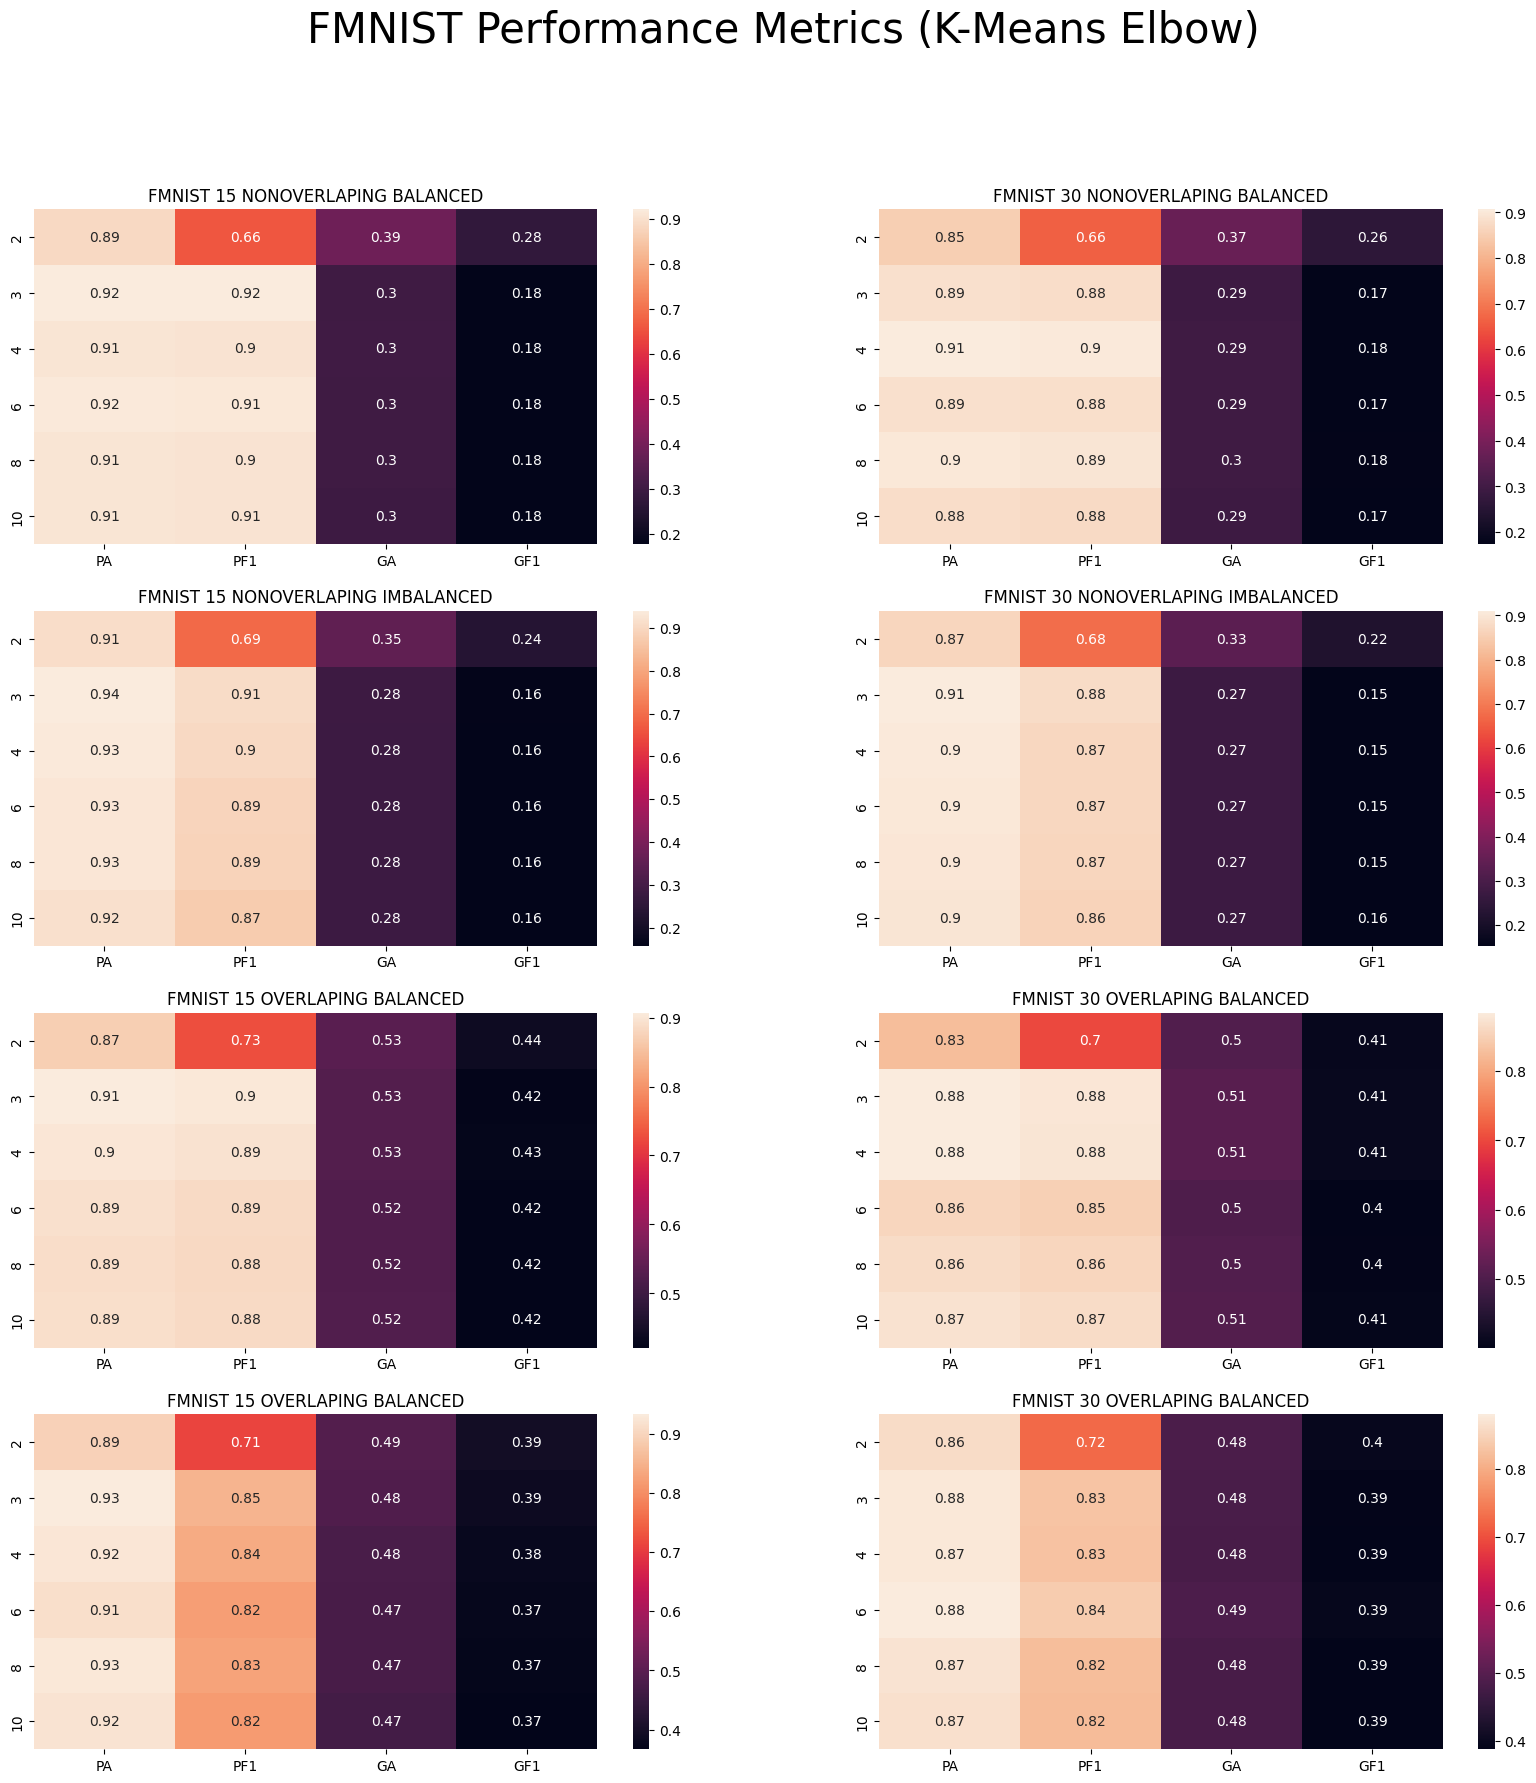

In [12]:
fig, ax = plt.subplots(4, 2, figsize=(20, 20))
fig.suptitle("FMNIST Performance Metrics (K-Means Elbow)", fontsize=30)

# FMNIST NONOVERLAPING BALANCED
sns.heatmap(learning_avg_per_scenario['FMNIST_15_nonoverlaping_balanced'].astype(float), ax=ax[0][0], annot=True)
ax[0][0].set_title('FMNIST 15 NONOVERLAPING BALANCED')

sns.heatmap(learning_avg_per_scenario['FMNIST_30_nonoverlaping_balanced'].astype(float), ax=ax[0][1], annot=True)
ax[0][1].set_title('FMNIST 30 NONOVERLAPING BALANCED')

# FMNIST NONOVERLAPING IMBALANCED
sns.heatmap(learning_avg_per_scenario['FMNIST_15_nonoverlaping_imbalanced'].astype(float), ax=ax[1][0], annot=True)
ax[1][0].set_title('FMNIST 15 NONOVERLAPING IMBALANCED')

sns.heatmap(learning_avg_per_scenario['FMNIST_30_nonoverlaping_imbalanced'].astype(float), ax=ax[1][1], annot=True)
ax[1][1].set_title('FMNIST 30 NONOVERLAPING IMBALANCED')

# FMNIST OVERLAPING BALANCED
sns.heatmap(learning_avg_per_scenario['FMNIST_15_overlaping_balanced'].astype(float), ax=ax[2][0], annot=True)
ax[2][0].set_title('FMNIST 15 OVERLAPING BALANCED')

sns.heatmap(learning_avg_per_scenario['FMNIST_30_overlaping_balanced'].astype(float), ax=ax[2][1], annot=True)
ax[2][1].set_title('FMNIST 30 OVERLAPING BALANCED')

# FMNIST OVERLAPING IMBALANCED
sns.heatmap(learning_avg_per_scenario['FMNIST_15_overlaping_imbalanced'].astype(float), ax=ax[3][0], annot=True)
ax[3][0].set_title('FMNIST 15 OVERLAPING BALANCED')

sns.heatmap(learning_avg_per_scenario['FMNIST_30_overlaping_imbalanced'].astype(float), ax=ax[3][1], annot=True)
ax[3][1].set_title('FMNIST 30 OVERLAPING BALANCED')

Text(0.5, 1.0, 'CIFAR10 30 OVERLAPING BALANCED')

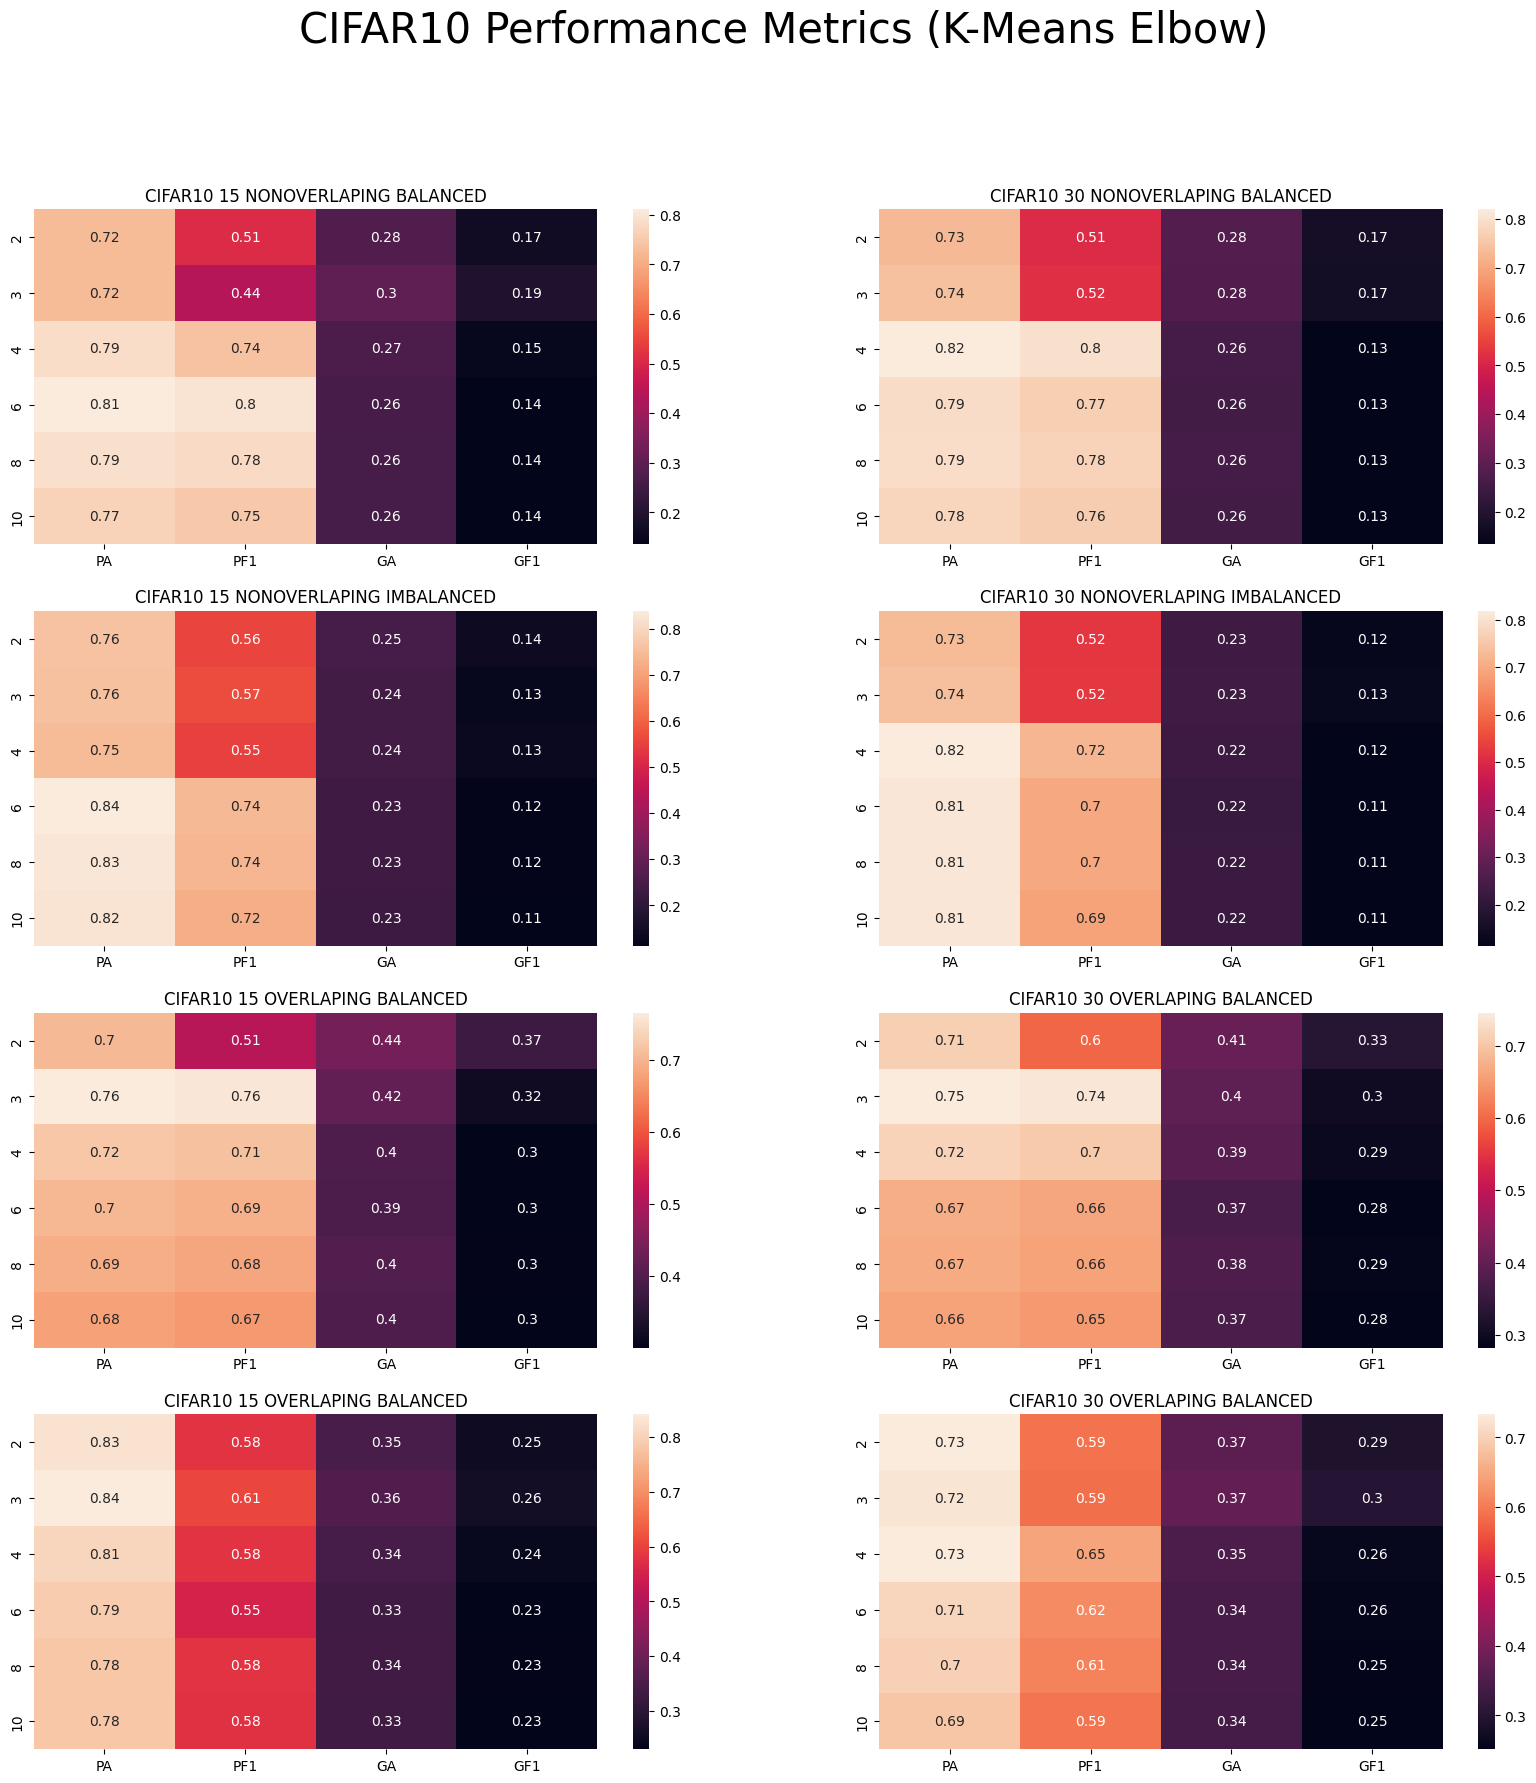

In [13]:
fig, ax = plt.subplots(4, 2, figsize=(20, 20))
fig.suptitle("CIFAR10 Performance Metrics (K-Means Elbow)", fontsize=30)

# FMNIST NONOVERLAPING BALANCED
sns.heatmap(learning_avg_per_scenario['CIFAR10_15_nonoverlaping_balanced'].astype(float), ax=ax[0][0], annot=True)
ax[0][0].set_title('CIFAR10 15 NONOVERLAPING BALANCED')

sns.heatmap(learning_avg_per_scenario['CIFAR10_30_nonoverlaping_balanced'].astype(float), ax=ax[0][1], annot=True)
ax[0][1].set_title('CIFAR10 30 NONOVERLAPING BALANCED')

# FMNIST NONOVERLAPING IMBALANCED
sns.heatmap(learning_avg_per_scenario['CIFAR10_15_nonoverlaping_imbalanced'].astype(float), ax=ax[1][0], annot=True)
ax[1][0].set_title('CIFAR10 15 NONOVERLAPING IMBALANCED')

sns.heatmap(learning_avg_per_scenario['CIFAR10_30_nonoverlaping_imbalanced'].astype(float), ax=ax[1][1], annot=True)
ax[1][1].set_title('CIFAR10 30 NONOVERLAPING IMBALANCED')

# FMNIST OVERLAPING BALANCED
sns.heatmap(learning_avg_per_scenario['CIFAR10_15_overlaping_balanced'].astype(float), ax=ax[2][0], annot=True)
ax[2][0].set_title('CIFAR10 15 OVERLAPING BALANCED')

sns.heatmap(learning_avg_per_scenario['CIFAR10_30_overlaping_balanced'].astype(float), ax=ax[2][1], annot=True)
ax[2][1].set_title('CIFAR10 30 OVERLAPING BALANCED')

# FMNIST OVERLAPING IMBALANCED
sns.heatmap(learning_avg_per_scenario['CIFAR10_15_overlaping_imbalanced'].astype(float), ax=ax[3][0], annot=True)
ax[3][0].set_title('CIFAR10 15 OVERLAPING BALANCED')

sns.heatmap(learning_avg_per_scenario['CIFAR10_30_overlaping_imbalanced'].astype(float), ax=ax[3][1], annot=True)
ax[3][1].set_title('CIFAR10 30 OVERLAPING BALANCED')

## Section IV: Clustering Evaluation
This section contains analysis of the clustering performance that was included in the Section IV.C of the final paper. Result in this section are presented in form of the heatmap, while the original paper contains the numerical table. It will create table under the path ```cwd/IEEE_BigData2024_Tables/Clustering_Performance```

In [14]:
def label_clusters(row):
    unique_values = row.unique()
    letter_digit = {}
    for number, value in enumerate(unique_values):
        letter_digit[value] = number
    row = row.replace(letter_digit)
    return row

def calculate_metric(row, metric, true_labels):
    return(metric(row, true_labels))

# Standard: "DATASET_{NUMBER OF CLIENTS}_{SPLIT TYPE}"
# 'NB' - Nonoverlaping Balanced
# 'NI' - Nonoverlaping Imbalanced
# 'OB' - Overlaping Balanced
# 'OI' - Overlaping Imbalanced
datasets = ['MNIST', 'FMNIST', 'CIFAR10']
no_of_clients = ['15', '30']
split_types = ['nonoverlaping', 'overlaping']
split_balance = ['balanced', 'imbalanced']
scenarios = [
    f"{dataset}_{clients}_{split}_{balance}"
    for dataset in datasets
    for clients in no_of_clients
    for split in split_types
    for balance in split_balance
]
algos = ['BNC', 'SCL', 'BCL', 'EFL-KMEANS', 'EFL-AFFINITY', 'EFL-MEANSHIFT', 'EFL-HDBSCAN']

clustering_info_stack = ['RAND', 'AMI', 'COM']
clustering_avg_per_scenario = {
    scenario: pd.DataFrame(index = algos, columns=clustering_info_stack)
    # RAND: Rand Score
    # AMI: Adjusted Mutual Information Score
    # COM: Cluster Completeness
    for scenario in scenarios
}

TRUE_LABELS = {
    'nonoverlaping_balanced_15': [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
    'nonoverlaping_imbalanced_15': [1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
    'overlaping_balanced_15': [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
    'overlaping_imbalanced_15': [1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
    'nonoverlaping_balanced_30': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    'nonoverlaping_imbalanced_30': [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    'overlaping_balanced_30': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    'overlaping_imbalanced_30': [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3]
}

In [17]:
for dataset in datasets:
    for no_clients in no_of_clients:
        for split in split_types:
            for balance in split_balance:
            
                # I. Clustering Correctness
                ROOT = os.path.join(os.getcwd(), f'experiments/{dataset}/{split}/{balance}/{no_clients}')
                BASELINE_ATT = pd.read_csv(os.path.join(ROOT, f'baseline_{dataset}_{split}_{balance}_{no_clients}/results/cluster_id_mapping.csv'))
                SATTLER_ATT = pd.read_csv(os.path.join(ROOT, f'sattler_{dataset}_{split}_{balance}_{no_clients}/results/cluster_id_mapping.csv'))
                BRIGGS_ATT = pd.read_csv(os.path.join(ROOT, f'briggs_{dataset}_{split}_{balance}_{no_clients}/results/cluster_id_mapping.csv'))
                KMEANS_ATT = pd.read_csv(os.path.join(ROOT, f'kmeans_{dataset}_{split}_{balance}_{no_clients}/results/cluster_id_mapping.csv'))
                AFFINITY_ATT = pd.read_csv(os.path.join(ROOT, f'affinity_{dataset}_{split}_{balance}_{no_clients}/results/cluster_id_mapping.csv'))
                MEAN_SHIFT_ATT = pd.read_csv(os.path.join(ROOT, f'meanshift_{dataset}_{split}_{balance}_{no_clients}/results/cluster_id_mapping.csv'))
                HDBSCAN_ATT = pd.read_csv(os.path.join(ROOT, f'HDBSCAN_{dataset}_{split}_{balance}_{no_clients}/results/cluster_id_mapping.csv'))
                
                true_labels = TRUE_LABELS[f'{split}_{balance}_{no_clients}']
                
                BASELINE_ATT_GROUPED = BASELINE_ATT.apply(label_clusters, axis=1)
                SATTLER_ATT_GROUPED = SATTLER_ATT.apply(label_clusters, axis=1)
                BRIGGS_ATT_GROUPED = BRIGGS_ATT.apply(label_clusters, axis=1)
                KMEANS_ATT_GROUPED = KMEANS_ATT.apply(label_clusters, axis=1)
                AFFINITY_ATT_GROUPED = AFFINITY_ATT.apply(label_clusters, axis=1)
                MEAN_SHIFT_ATT_GROUPED = MEAN_SHIFT_ATT.apply(label_clusters, axis=1)
                HDBSCAN_ATT_GROUPED = HDBSCAN_ATT.apply(label_clusters, axis=1)
                
                RAND_SCORES = pd.DataFrame(columns=['BNC', 'SCL', 'BCL', 'EFL-KMEANS', 'EFL-AFFINITY', 'EFL-MEANSHIFT', 'EFL-HDBSCAN'], index=range(50))
                RAND_SCORES['BNC'] = BASELINE_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                RAND_SCORES['SCL'] = SATTLER_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                RAND_SCORES['BCL'] = BRIGGS_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                RAND_SCORES['EFL-KMEANS'] = KMEANS_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                RAND_SCORES['EFL-AFFINITY'] = AFFINITY_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                RAND_SCORES['EFL-MEANSHIFT'] = MEAN_SHIFT_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                RAND_SCORES['EFL-HDBSCAN'] = HDBSCAN_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                
                MIS_SCORES = pd.DataFrame(columns=['BNC', 'SCL', 'BCL', 'EFL-KMEANS', 'EFL-AFFINITY', 'EFL-MEANSHIFT', 'EFL-HDBSCAN'], index=range(50))
                MIS_SCORES['BNC'] = BASELINE_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_mutual_info_score, true_labels = true_labels, axis=1)
                MIS_SCORES['SCL'] = SATTLER_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_mutual_info_score, true_labels = true_labels, axis=1)
                MIS_SCORES['BCL'] = BRIGGS_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_mutual_info_score, true_labels = true_labels, axis=1)
                MIS_SCORES['EFL-KMEANS'] = KMEANS_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_mutual_info_score, true_labels = true_labels, axis=1)
                MIS_SCORES['EFL-AFFINITY'] = AFFINITY_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_mutual_info_score, true_labels = true_labels, axis=1)
                MIS_SCORES['EFL-MEANSHIFT'] = MEAN_SHIFT_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_mutual_info_score, true_labels = true_labels, axis=1)
                MIS_SCORES['EFL-HDBSCAN'] = HDBSCAN_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                
                COM_SCORES = pd.DataFrame(columns=['BNC', 'SCL', 'BCL', 'EFL-KMEANS', 'EFL-AFFINITY', 'EFL-MEANSHIFT', 'EFL-HDBSCAN'], index=range(50))
                COM_SCORES['BNC'] = BASELINE_ATT_GROUPED.apply(calculate_metric, metric = metrics.completeness_score, true_labels = true_labels, axis=1)
                COM_SCORES['SCL'] = SATTLER_ATT_GROUPED.apply(calculate_metric, metric = metrics.completeness_score, true_labels = true_labels, axis=1)
                COM_SCORES['BCL'] = BRIGGS_ATT_GROUPED.apply(calculate_metric, metric = metrics.completeness_score, true_labels = true_labels, axis=1)
                COM_SCORES['EFL-KMEANS'] = KMEANS_ATT_GROUPED.apply(calculate_metric, metric = metrics.completeness_score, true_labels = true_labels, axis=1)
                COM_SCORES['EFL-AFFINITY'] = AFFINITY_ATT_GROUPED.apply(calculate_metric, metric = metrics.completeness_score, true_labels = true_labels, axis=1)
                COM_SCORES['EFL-MEANSHIFT'] = MEAN_SHIFT_ATT_GROUPED.apply(calculate_metric, metric = metrics.completeness_score, true_labels = true_labels, axis=1)
                COM_SCORES['EFL-HDBSCAN'] = HDBSCAN_ATT_GROUPED.apply(calculate_metric, metric = metrics.completeness_score, true_labels = true_labels, axis=1)
                
                key = f'{dataset}_{no_clients}_{split}_{balance}'
                clustering_avg_per_scenario[key]['RAND'] = RAND_SCORES.mean()
                clustering_avg_per_scenario[key]['AMI'] = MIS_SCORES.mean()
                clustering_avg_per_scenario[key]['COM'] = COM_SCORES.mean()
                if not os.path.exists(os.path.join(os.getcwd(), 'IEEE_BigData2024_Tables', 'Clustering_Performance')):
                    os.makedirs(os.path.join(os.getcwd(), 'IEEE_BigData2024_Tables', 'Clustering_Performance'))
                
                with open(os.path.join(os.getcwd(), 'IEEE_BigData2024_Tables', 'Clustering_Performance', f"{key}.tex"), 'w+') as file:
                    file.write(clustering_avg_per_scenario[key].to_latex())
                
                

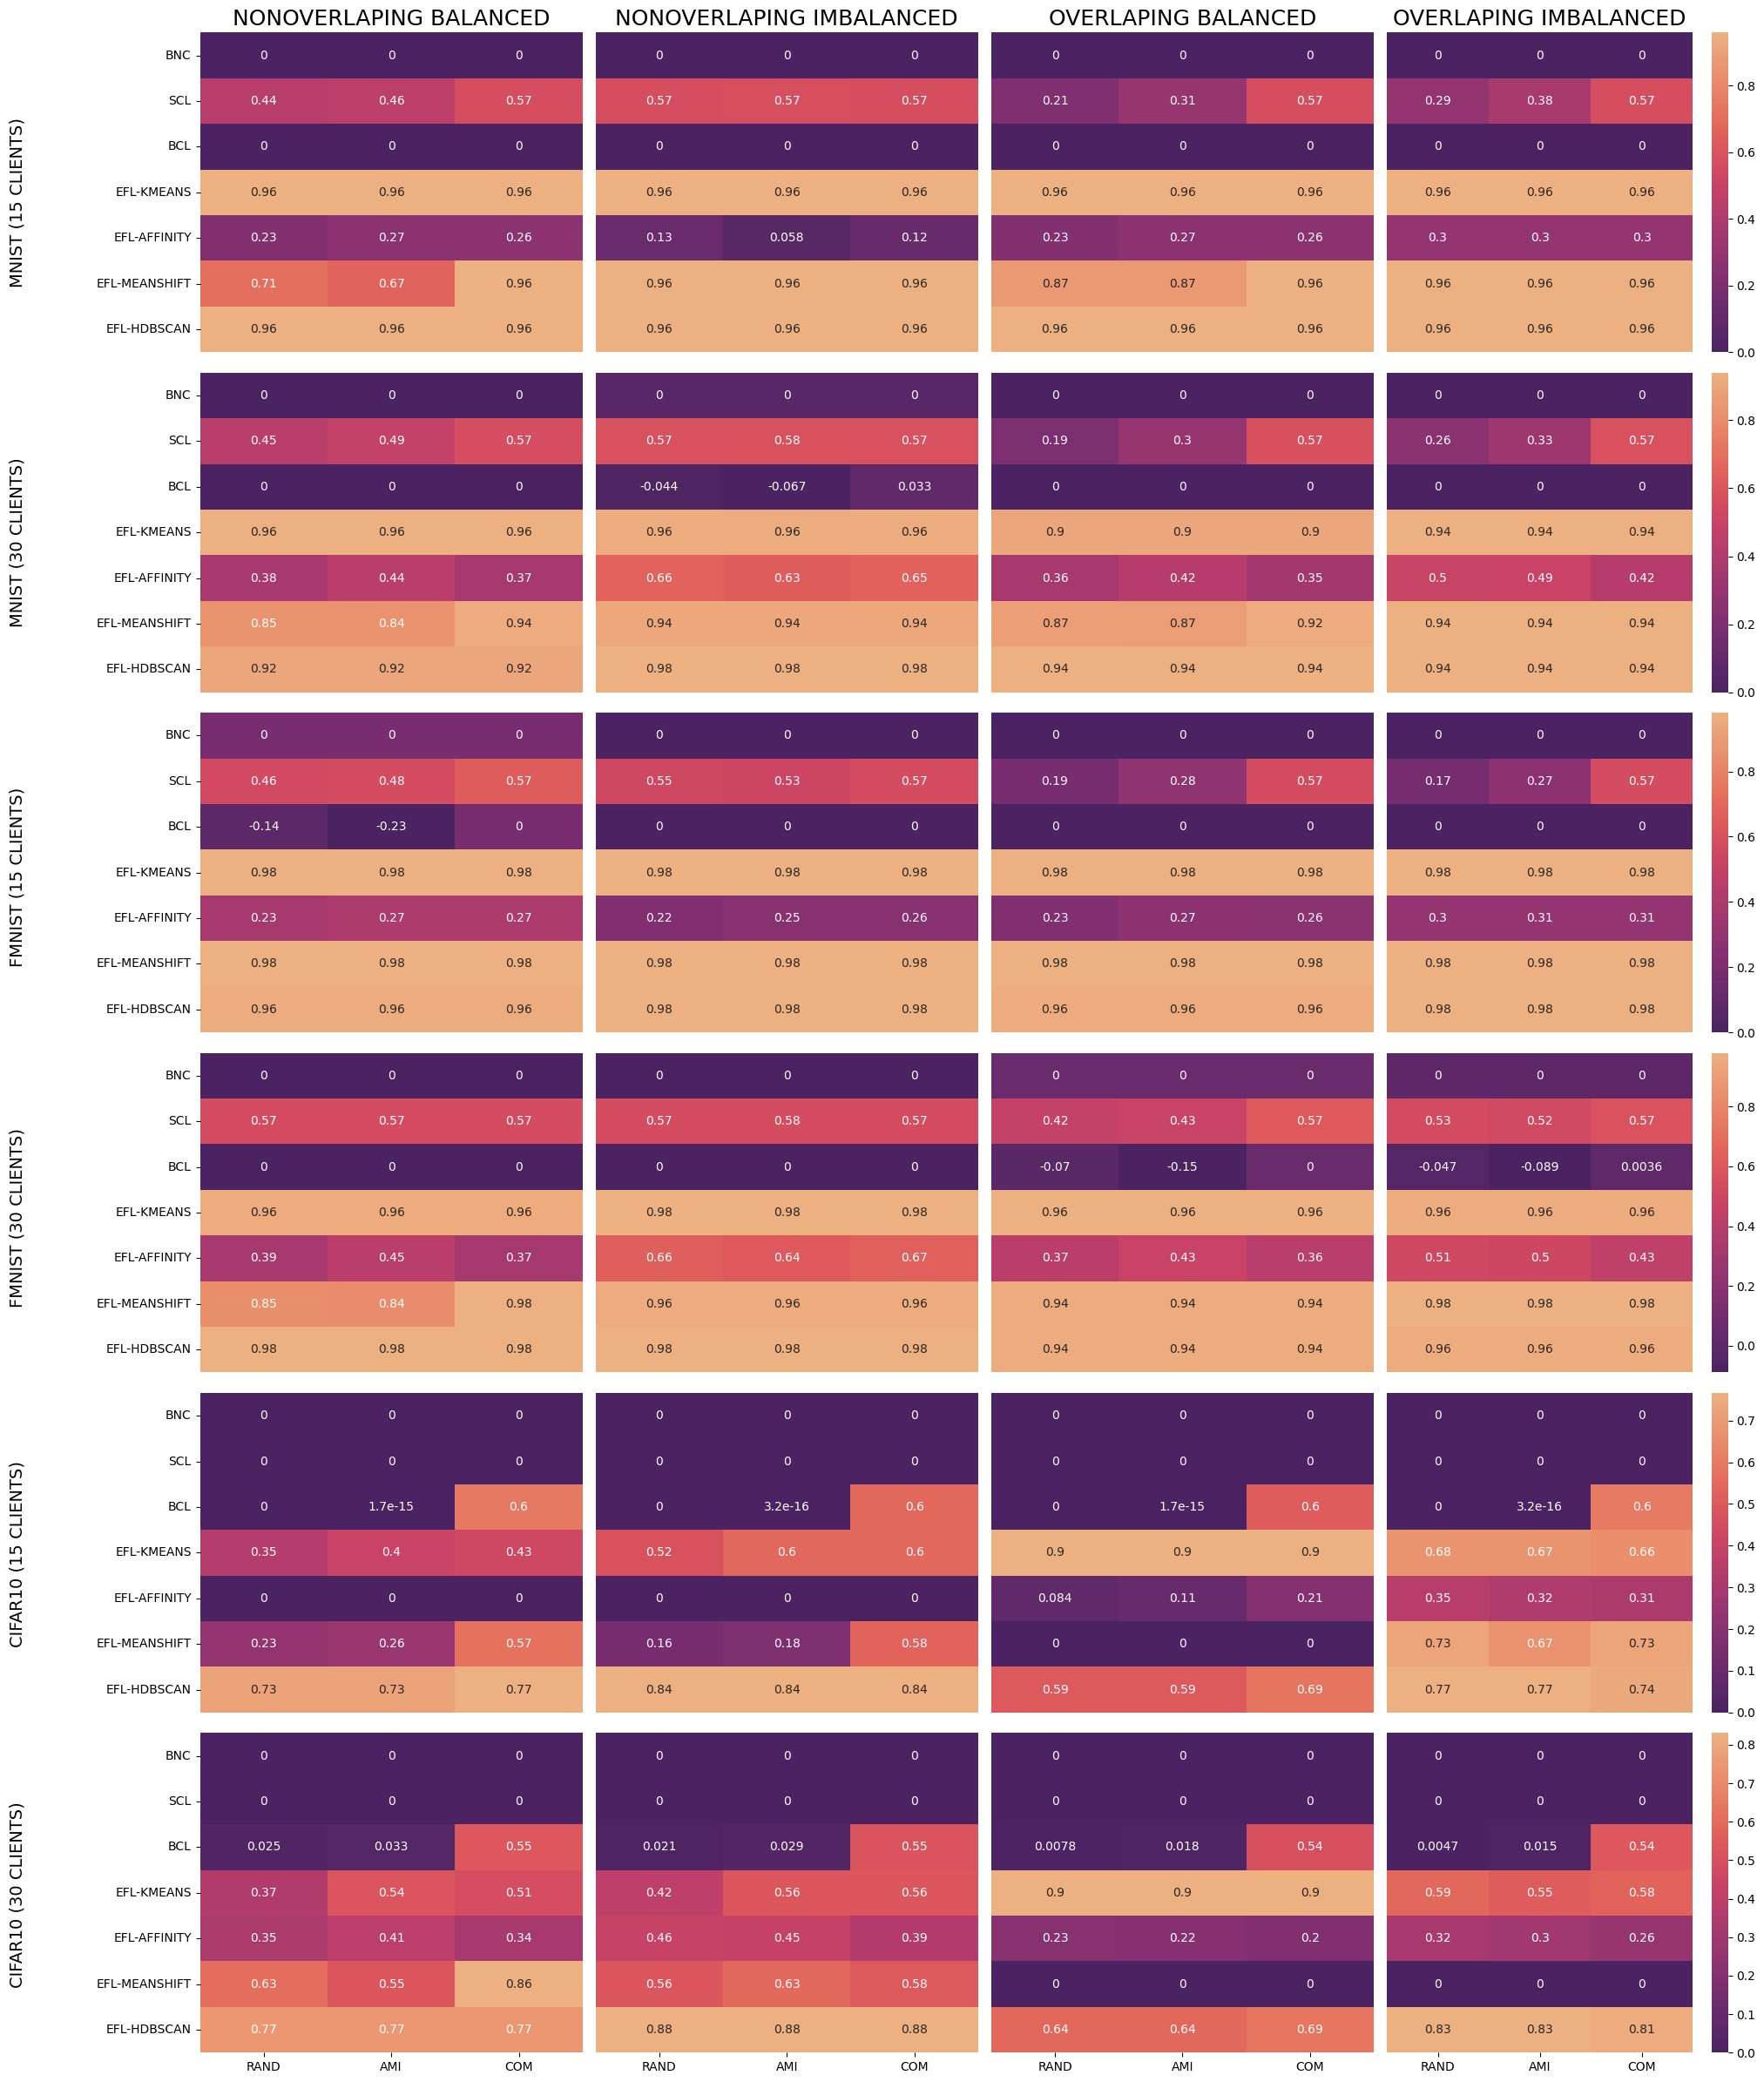

In [18]:
fig, ax = plt.subplots(6, 4, figsize=(20, 24))

### MNIST
## MNIST 15 CLIENTS
# MNIST NONOVERLAPING BALANCED
sns.heatmap(clustering_avg_per_scenario['MNIST_15_nonoverlaping_balanced'], ax=ax[0][0], annot=True, cmap=PALETTE, cbar=False)
ax[0][0].set_title('NONOVERLAPING BALANCED', fontsize=18)
ax[0][0].get_xaxis().set_ticks([])
ax[0][0].text(-1.5, 5.5, 'MNIST (15 CLIENTS)', fontsize=14, rotation = 270, rotation_mode = 'default', transform_rotates_text=True)

# MNIST NONOVERLAPING IMBALANCED
sns.heatmap(clustering_avg_per_scenario['MNIST_15_nonoverlaping_imbalanced'], ax=ax[0][1], annot=True, cmap=PALETTE, cbar=False)
ax[0][1].set_title('NONOVERLAPING IMBALANCED', fontsize=18)
ax[0][1].get_xaxis().set_ticks([])
ax[0][1].get_yaxis().set_ticks([])

# MNIST OVERLAPING BALANCED
sns.heatmap(clustering_avg_per_scenario['MNIST_15_overlaping_balanced'], ax=ax[0][2], annot=True, cmap=PALETTE, cbar=False)
ax[0][2].set_title('OVERLAPING BALANCED', fontsize=18)
ax[0][2].get_xaxis().set_ticks([])
ax[0][2].get_yaxis().set_ticks([])

# MNIST OVERLAPING IMBALANCED
sns.heatmap(clustering_avg_per_scenario['MNIST_15_overlaping_imbalanced'], ax=ax[0][3], annot=True, cmap=PALETTE)
ax[0][3].set_title('OVERLAPING IMBALANCED', fontsize=18)
ax[0][3].get_xaxis().set_ticks([])
ax[0][3].get_yaxis().set_ticks([])

## MNIST 30 CLIENTS
# MNIST NONOVERLAPING BALANCED
sns.heatmap(clustering_avg_per_scenario['MNIST_30_nonoverlaping_balanced'], ax=ax[1][0], annot=True, cmap=PALETTE, cbar=False)
ax[1][0].get_xaxis().set_ticks([])
ax[1][0].text(-1.5, 5.5, 'MNIST (30 CLIENTS)', fontsize=14, rotation = 270, rotation_mode = 'default', transform_rotates_text=True)

# MNIST NONOVERLAPING IMBALANCED
sns.heatmap(clustering_avg_per_scenario['MNIST_30_nonoverlaping_imbalanced'], ax=ax[1][1], annot=True, cmap=PALETTE, cbar=False)
ax[1][1].get_xaxis().set_ticks([])
ax[1][1].get_yaxis().set_ticks([])

# MNIST OVERLAPING BALANCED
sns.heatmap(clustering_avg_per_scenario['MNIST_30_overlaping_balanced'], ax=ax[1][2], annot=True, cmap=PALETTE, cbar=False)
ax[1][2].get_xaxis().set_ticks([])
ax[1][2].get_yaxis().set_ticks([])

# MNIST OVERLAPING IMBALANCED
sns.heatmap(clustering_avg_per_scenario['MNIST_30_overlaping_imbalanced'], ax=ax[1][3], annot=True, cmap=PALETTE)
ax[1][3].get_xaxis().set_ticks([])
ax[1][3].get_yaxis().set_ticks([])

### FMNIST
## FMNIST 15 CLIENTS
# FMNIST NONOVERLAPING BALANCED
sns.heatmap(clustering_avg_per_scenario['FMNIST_15_nonoverlaping_balanced'], ax=ax[2][0], annot=True, cmap=PALETTE, cbar=False)
ax[2][0].get_xaxis().set_ticks([])
ax[2][0].text(-1.5, 5.5, 'FMNIST (15 CLIENTS)', fontsize=14, rotation = 270, rotation_mode = 'default', transform_rotates_text=True)

# FMNIST NONOVERLAPING IMBALANCED
sns.heatmap(clustering_avg_per_scenario['FMNIST_15_nonoverlaping_imbalanced'], ax=ax[2][1], annot=True, cmap=PALETTE, cbar=False)
ax[2][1].get_xaxis().set_ticks([])
ax[2][1].get_yaxis().set_ticks([])

# FMNIST OVERLAPING BALANCED
sns.heatmap(clustering_avg_per_scenario['FMNIST_15_overlaping_balanced'], ax=ax[2][2], annot=True, cmap=PALETTE, cbar=False)
ax[2][2].get_xaxis().set_ticks([])
ax[2][2].get_yaxis().set_ticks([])

# FMNIST OVERLAPING IMBALANCED
sns.heatmap(clustering_avg_per_scenario['FMNIST_15_overlaping_imbalanced'], ax=ax[2][3], annot=True, cmap=PALETTE)
ax[2][3].get_xaxis().set_ticks([])
ax[2][3].get_yaxis().set_ticks([])

## MFNIST 30 CLIENTS
# MNIST NONOVERLAPING BALANCED
sns.heatmap(clustering_avg_per_scenario['FMNIST_30_nonoverlaping_balanced'], ax=ax[3][0], annot=True, cmap=PALETTE, cbar=False)
ax[3][0].get_xaxis().set_ticks([])
ax[3][0].text(-1.5, 5.5, 'FMNIST (30 CLIENTS)', fontsize=14, rotation = 270, rotation_mode = 'default', transform_rotates_text=True)

# FMNIST NONOVERLAPING IMBALANCED
sns.heatmap(clustering_avg_per_scenario['FMNIST_30_nonoverlaping_imbalanced'], ax=ax[3][1], annot=True, cmap=PALETTE, cbar=False)
ax[3][1].get_xaxis().set_ticks([])
ax[3][1].get_yaxis().set_ticks([])

# FMNIST OVERLAPING BALANCED
sns.heatmap(clustering_avg_per_scenario['FMNIST_30_overlaping_balanced'], ax=ax[3][2], annot=True, cmap=PALETTE, cbar=False)
ax[3][2].get_xaxis().set_ticks([])
ax[3][2].get_yaxis().set_ticks([])

# FMNIST OVERLAPING IMBALANCED
sns.heatmap(clustering_avg_per_scenario['FMNIST_30_overlaping_imbalanced'], ax=ax[3][3], annot=True, cmap=PALETTE)
ax[3][3].get_xaxis().set_ticks([])
ax[3][3].get_yaxis().set_ticks([])


### CIFAR
## CIFAR 15 CLIENTS
# CIFAR NONOVERLAPING BALANCED
sns.heatmap(clustering_avg_per_scenario['CIFAR10_15_nonoverlaping_balanced'], ax=ax[4][0], annot=True, cmap=PALETTE, cbar=False)
ax[4][0].get_xaxis().set_ticks([])
ax[4][0].text(-1.5, 5.5, 'CIFAR10 (15 CLIENTS)', fontsize=14, rotation = 270, rotation_mode = 'default', transform_rotates_text=True)

# CIFAR NONOVERLAPING IMBALANCED
sns.heatmap(clustering_avg_per_scenario['CIFAR10_15_nonoverlaping_imbalanced'], ax=ax[4][1], annot=True, cmap=PALETTE, cbar=False)
ax[4][1].get_xaxis().set_ticks([])
ax[4][1].get_yaxis().set_ticks([])

# CIFAR OVERLAPING BALANCED
sns.heatmap(clustering_avg_per_scenario['CIFAR10_15_overlaping_balanced'], ax=ax[4][2], annot=True, cmap=PALETTE, cbar=False)
ax[4][2].get_xaxis().set_ticks([])
ax[4][2].get_yaxis().set_ticks([])

# CIFAR OVERLAPING IMBALANCED
sns.heatmap(clustering_avg_per_scenario['CIFAR10_15_overlaping_imbalanced'], ax=ax[4][3], annot=True, cmap=PALETTE)
ax[4][3].get_xaxis().set_ticks([])
ax[4][3].get_yaxis().set_ticks([])

## CIFAR 30 CLIENTS
# CIFAR NONOVERLAPING BALANCED
sns.heatmap(clustering_avg_per_scenario['CIFAR10_30_nonoverlaping_balanced'], ax=ax[5][0], annot=True, cmap=PALETTE, cbar=False)
ax[5][0].text(-1.5, 5.5, 'CIFAR10 (30 CLIENTS)', fontsize=14, rotation = 270, rotation_mode = 'default', transform_rotates_text=True)

# CIFAR NONOVERLAPING IMBALANCED
sns.heatmap(clustering_avg_per_scenario['CIFAR10_30_nonoverlaping_imbalanced'], ax=ax[5][1], annot=True, cmap=PALETTE, cbar=False)
ax[5][1].get_yaxis().set_ticks([])

# CIFAR OVERLAPING BALANCED
sns.heatmap(clustering_avg_per_scenario['CIFAR10_30_overlaping_balanced'], ax=ax[5][2], annot=True, cmap=PALETTE, cbar=False)
ax[5][2].get_yaxis().set_ticks([])

# CIFAR OVERLAPING IMBALANCED
sns.heatmap(clustering_avg_per_scenario['CIFAR10_30_overlaping_imbalanced'], ax=ax[5][3], annot=True, cmap=PALETTE)
ax[5][3].get_yaxis().set_ticks([])

plt.tight_layout()

## Section V: Behaviour of Temperature Function
This section contains analysis of the behaviour of the temperature function that was included in the Section IV.E of the final paper.

In [19]:
# Root directory for an experiment
ROOT = os.path.join(os.getcwd(), 'temperature_experiments')
# Available datasets
datasets = ['MNIST', 'FMNIST']
# Number of clients
no_of_clients = ['15', '30']
# Types of splits in terms of overlap
split_types = ['nonoverlaping', 'overlaping']
# Types of splits in terms of balance
split_balance = ['balanced', 'imbalanced']

In [20]:
registered_temperature = {}
for dataset in datasets:
    for type in split_types:
        for balance in split_balance:
            for no in no_of_clients:
                path = os.path.join(ROOT, dataset, type, balance, no)
                dir_name = f"{dataset}_{type}_{balance}_{no}"
                registered_temperature[dir_name] = pd.read_csv(os.path.join(ROOT, dataset, type, balance, no, \
                    dir_name, 'results', 'clusters_temperature.csv'), names=['temperature'], index_col=0)

In [21]:
# Stacking frames
frames = [registered_temperature['MNIST_nonoverlaping_balanced_15'], 
          registered_temperature['MNIST_overlaping_imbalanced_15'], 
          registered_temperature['MNIST_overlaping_balanced_15']['temperature'], 
          registered_temperature['MNIST_overlaping_imbalanced_15']['temperature']]
mnist_15_stacked = pd.concat(frames, axis=1)

frames = [registered_temperature['MNIST_nonoverlaping_balanced_30'], 
          registered_temperature['MNIST_overlaping_imbalanced_30'], 
          registered_temperature['MNIST_overlaping_balanced_30']['temperature'], 
          registered_temperature['MNIST_overlaping_imbalanced_30']['temperature']]
mnist_30_stacked = pd.concat(frames, axis=1)

frames = [registered_temperature['FMNIST_nonoverlaping_balanced_15'], 
          registered_temperature['FMNIST_overlaping_imbalanced_15'], 
          registered_temperature['FMNIST_overlaping_balanced_15']['temperature'], 
          registered_temperature['FMNIST_overlaping_imbalanced_15']['temperature']]
fmnist_15_stacked = pd.concat(frames, axis=1)

frames = [registered_temperature['FMNIST_nonoverlaping_balanced_30'], 
          registered_temperature['FMNIST_overlaping_imbalanced_30'], 
          registered_temperature['FMNIST_overlaping_balanced_30']['temperature'], 
          registered_temperature['FMNIST_overlaping_imbalanced_30']['temperature']]
fmnist_30_stacked = pd.concat(frames, axis=1)

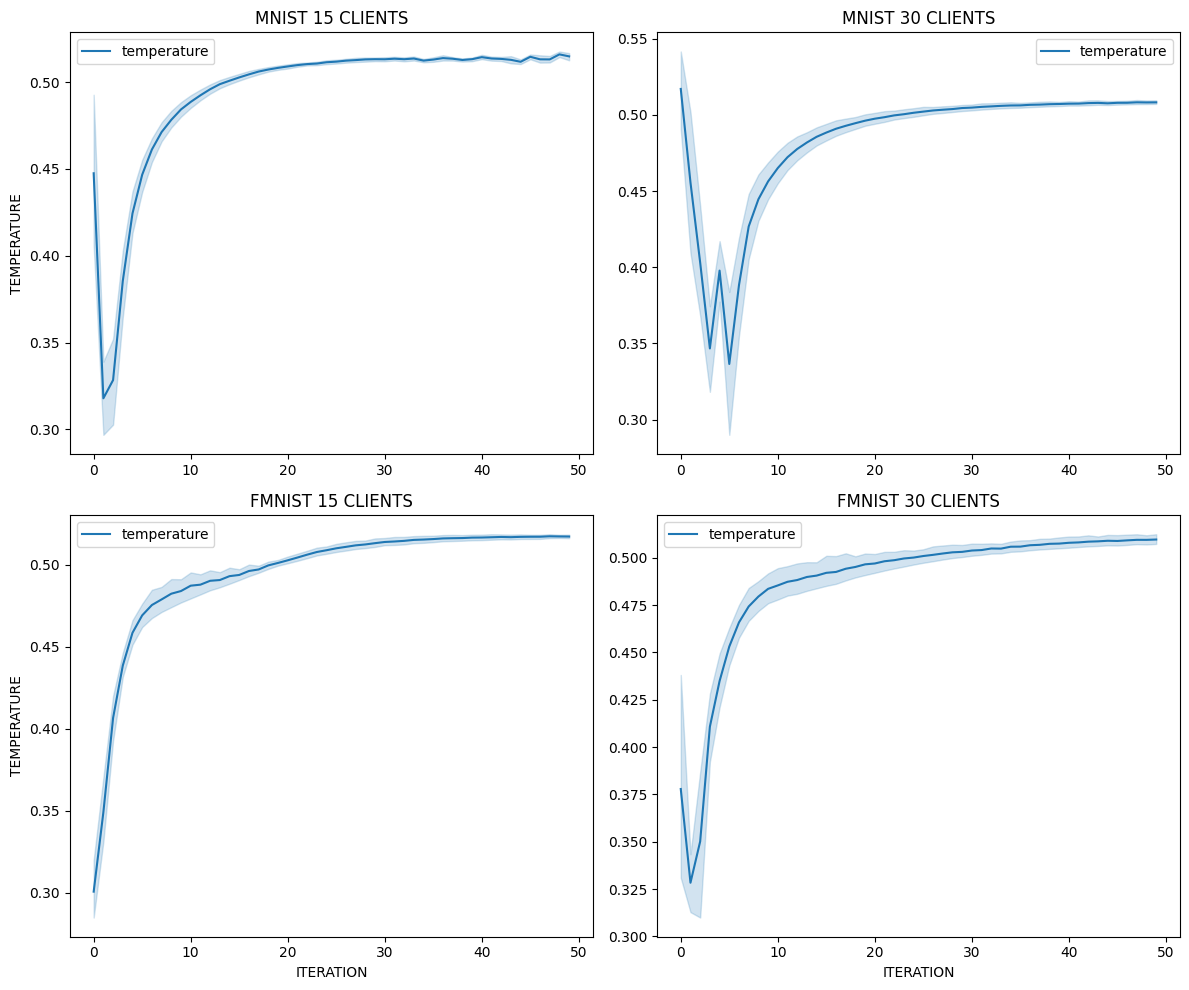

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Mnist 15 stakced
sns.lineplot(mnist_15_stacked, ax=axes[0][0])
axes[0][0].set_title('MNIST 15 CLIENTS')
axes[0][0].set_ylabel("TEMPERATURE")

# MNIST 30 stakced
sns.lineplot(mnist_30_stacked, ax=axes[0][1])
axes[0][1].set_title("MNIST 30 CLIENTS")

# FMNIST 15 stacked
sns.lineplot(fmnist_15_stacked, ax=axes[1][0])
axes[1][0].set_title("FMNIST 15 CLIENTS")
axes[1][0].set_ylabel("TEMPERATURE")
axes[1][0].set_xlabel("ITERATION")

# FNIST 30 stacked
sns.lineplot(fmnist_30_stacked, ax=axes[1][1])
axes[1][1].set_title("FMNIST 30 CLIENTS")
axes[1][1].set_xlabel("ITERATION")

plt.tight_layout()